In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import geopandas as gpd
import plotly.graph_objects as go


In [2]:
building_damage_assessment = pd.read_csv("../csv_files/csv_building_damage_assessment.csv",low_memory=False)
name_mapping = pd.read_csv("../csv_files/ward_vdcmun_district_name_mapping.csv",low_memory=False)
earthquake_impact = pd.read_csv("../csv_files/csv_household_earthquake_impact.csv",low_memory=False)
individual_demographics = pd.read_csv("../csv_files/csv_individual_demographics.csv",low_memory=False)

In [3]:
district_id_name_dict = name_mapping.set_index('district_id')['district_name'].to_dict()

In [4]:
duplicates = name_mapping[name_mapping.duplicated(subset='vdcmun_id', keep=False)]
name_mapping = name_mapping.drop_duplicates(subset='vdcmun_id')
vdcmun_id_name_dict = name_mapping.set_index('vdcmun_id')['vdcmun_name'].to_dict()

In [5]:
main_df_columns = pd.DataFrame()

In [6]:
main_df_columns["vdcmun_id"] = building_damage_assessment["vdcmun_id"]
main_df_columns["district_id"] = building_damage_assessment["district_id"]
main_df_columns["vdcmun_name"] = main_df_columns["vdcmun_id"].map(vdcmun_id_name_dict)
main_df_columns["district_name"] = main_df_columns["district_id"].map(district_id_name_dict)

In [7]:
# remove duplicates from main_df_columns
main_df_columns = main_df_columns.drop_duplicates(subset='vdcmun_id')
main_df_columns = main_df_columns.reset_index(drop=True)

In [8]:
main_df_columns = main_df_columns.sort_values(by=['district_id', 'vdcmun_id']).reset_index(drop=True)

In [9]:
# these cols are in earthquake_impact
death_occurred = earthquake_impact["has_death_occurred_last_12_months"]
count_death = earthquake_impact["count_death_last_12_months"]
injury_occurred = earthquake_impact["has_injury_loss_occurred_last_12_months"]
count_injury = earthquake_impact["count_injury_loss_last_12_months"]

In [10]:
# Aggregating counts by district_id and vdcmun_id
district_aggregates = earthquake_impact.groupby("district_id").agg(
    total_deaths=("count_death_last_12_months", "sum"),
    total_injuries=("count_injury_loss_last_12_months", "sum"),
    death_cases=("has_death_occurred_last_12_months", "sum"),
    injury_cases=("has_injury_loss_occurred_last_12_months", "sum")
).reset_index()

vdcmun_aggregates = earthquake_impact.groupby("vdcmun_id").agg(
    total_deaths=("count_death_last_12_months", "sum"),
    total_injuries=("count_injury_loss_last_12_months", "sum"),
    death_cases=("has_death_occurred_last_12_months", "sum"),
    injury_cases=("has_injury_loss_occurred_last_12_months", "sum")
).reset_index()

In [11]:
# Adding aggregated data to main_df_columns
main_df_columns = main_df_columns.merge(district_aggregates, on="district_id", how="left")
main_df_columns = main_df_columns.merge(vdcmun_aggregates, on="vdcmun_id", how="left")

# Renaming columns for clarity
main_df_columns.rename(columns={
    "total_deaths_x": "district_total_deaths",
    "total_injuries_x": "district_total_injuries",
    "death_cases_x": "district_death_cases",
    "injury_cases_x": "district_injury_cases",
    "total_deaths_y": "vdcmun_total_deaths",
    "total_injuries_y": "vdcmun_total_injuries",
    "death_cases_y": "vdcmun_death_cases",
    "injury_cases_y": "vdcmun_injury_cases"
}, inplace=True)


In [12]:
# Dictionary holding the population count for each district
district_population_dict = (
    individual_demographics.groupby('district_id')['individual_id']
    .count()
    .to_dict()
)

# Dictionary holding the population count for each VDC/Municipality
vdcmun_population_dict = (
    individual_demographics.groupby('vdcmun_id')['individual_id']
    .count()
    .to_dict()
)


In [13]:
# Add population data to main_df_columns
main_df_columns['district_population'] = main_df_columns['district_id'].map(district_population_dict)
main_df_columns['vdcmun_population'] = main_df_columns['vdcmun_id'].map(vdcmun_population_dict)


In [14]:
temp_copy = main_df_columns.copy()

In [15]:
# Calculating per capita metrics for district and VDC/Municipality level
main_df_columns['district_deaths_per_1000'] = (
    main_df_columns['district_total_deaths'] / main_df_columns['district_population'] * 1000
)
main_df_columns['district_injuries_per_1000'] = (
    main_df_columns['district_total_injuries'] / main_df_columns['district_population'] * 1000
)

main_df_columns['vdcmun_deaths_per_1000'] = (
    main_df_columns['vdcmun_total_deaths'] / main_df_columns['vdcmun_population'] * 1000
)
main_df_columns['vdcmun_injuries_per_1000'] = (
    main_df_columns['vdcmun_total_injuries'] / main_df_columns['vdcmun_population'] * 1000
)

In [16]:
main_df_columns

,vdcmun_id,district_id,vdcmun_name,district_name,district_total_deaths,district_total_injuries,district_death_cases,district_injury_cases,vdcmun_total_deaths,vdcmun_total_injuries,vdcmun_death_cases,vdcmun_injury_cases,district_population,vdcmun_population,district_deaths_per_1000,district_injuries_per_1000,vdcmun_deaths_per_1000,vdcmun_injuries_per_1000
0,1201,12,Champadevi Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,82.0,31.0,79.0,31.0,190248,26275,3.332492,0.982928,3.120837,1.179829
1,1202,12,Chishankhu Gadhi Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,59.0,8.0,53.0,8.0,190248,17001,3.332492,0.982928,3.470384,0.470561
2,1203,12,Khiji Demba Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,101.0,48.0,96.0,48.0,190248,19192,3.332492,0.982928,5.262609,2.501042
3,1204,12,Likhu Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,69.0,20.0,67.0,19.0,190248,21544,3.332492,0.982928,3.202748,0.928333
4,1205,12,Manebhanjyang Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,42.0,12.0,42.0,12.0,190248,25968,3.332492,0.982928,1.617375,0.462107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,3607,36,Gandaki Rural Municipality,Gorkha,1757.0,968.0,1683.0,905.0,120.0,59.0,116.0,59.0,360323,27847,4.876181,2.686479,4.309261,2.118720
106,3608,36,Gorkha Municipality,Gorkha,1757.0,968.0,1683.0,905.0,230.0,79.0,220.0,78.0,360323,57777,4.876181,2.686479,3.980823,1.367326
107,3609,36,Palungtar Municipality,Gorkha,1757.0,968.0,1683.0,905.0,196.0,63.0,192.0,59.0,360323,52157,4.876181,2.686479,3.757885,1.207892
108,3610,36,Shahid Lakhan Rural Municipality,Gorkha,1757.0,968.0,1683.0,905.0,127.0,54.0,125.0,51.0,360323,35206,4.876181,2.686479,3.607340,1.533829


In [17]:
# count the number of values in these columns
column_counts = ["has_geotechnical_risk",
                "has_geotechnical_risk_land_settlement",
                "has_geotechnical_risk_fault_crack",
                "has_geotechnical_risk_liquefaction",
                "has_geotechnical_risk_landslide",
                "has_geotechnical_risk_rock_fall",
                "has_geotechnical_risk_flood",
                "has_geotechnical_risk_other",]
print("Count of values in columns")
for col in column_counts:
    print(f"{col}: {building_damage_assessment[col].value_counts()}")

Count of values in columns
has_geotechnical_risk: has_geotechnical_risk
0.0    652447
1.0    109647
Name: count, dtype: int64
has_geotechnical_risk_land_settlement: has_geotechnical_risk_land_settlement
0    733055
1     29051
Name: count, dtype: int64
has_geotechnical_risk_fault_crack: has_geotechnical_risk_fault_crack
0    721558
1     40548
Name: count, dtype: int64
has_geotechnical_risk_liquefaction: has_geotechnical_risk_liquefaction
0    759976
1      2130
Name: count, dtype: int64
has_geotechnical_risk_landslide: has_geotechnical_risk_landslide
0    701032
1     61074
Name: count, dtype: int64
has_geotechnical_risk_rock_fall: has_geotechnical_risk_rock_fall
0    730113
1     31993
Name: count, dtype: int64
has_geotechnical_risk_flood: has_geotechnical_risk_flood
0    753175
1      8931
Name: count, dtype: int64
has_geotechnical_risk_other: has_geotechnical_risk_other
0    761291
1       815
Name: count, dtype: int64


In [18]:

# 1.----------------------------------------------------------------------- #
has_geotechnical_risk_district = (
    building_damage_assessment.groupby('district_id')['has_geotechnical_risk']
    .sum()
    .to_dict()
)
has_geotechnical_risk_vdcmun = (
    building_damage_assessment.groupby('vdcmun_id')['has_geotechnical_risk']
    .sum()
    .to_dict()
)
# ----------------------------------------------------------------------- #

# 2.----------------------------------------------------------------------- #
has_geotechnical_risk_land_settlement_district = (
    building_damage_assessment.groupby('district_id')['has_geotechnical_risk_land_settlement']
    .sum()
    .to_dict()
)
has_geotechnical_risk_land_settlement_vdcmun = (
    building_damage_assessment.groupby('vdcmun_id')['has_geotechnical_risk_land_settlement']
    .sum()
    .to_dict()
)
# ----------------------------------------------------------------------- #

# 3.----------------------------------------------------------------------- #
has_geotechnical_risk_fault_crack_district = (
    building_damage_assessment.groupby('district_id')['has_geotechnical_risk_fault_crack']
    .sum()
    .to_dict()
)
has_geotechnical_risk_fault_crack_vdcmun = (
    building_damage_assessment.groupby('vdcmun_id')['has_geotechnical_risk_fault_crack']
    .sum()
    .to_dict()
)
# ----------------------------------------------------------------------- #

# 4.----------------------------------------------------------------------- #
has_geotechnical_risk_liquefaction_district = (
    building_damage_assessment.groupby('district_id')['has_geotechnical_risk_liquefaction']
    .sum()
    .to_dict()
)
has_geotechnical_risk_liquefaction_vdcmun = (
    building_damage_assessment.groupby('vdcmun_id')['has_geotechnical_risk_liquefaction']
    .sum()
    .to_dict()
)
# ----------------------------------------------------------------------- #

# 5.----------------------------------------------------------------------- #
has_geotechnical_risk_landslide_district = (
    building_damage_assessment.groupby('district_id')['has_geotechnical_risk_landslide']
    .sum()
    .to_dict()
)
has_geotechnical_risk_landslide_vdcmun = (
    building_damage_assessment.groupby('vdcmun_id')['has_geotechnical_risk_landslide']
    .sum()
    .to_dict()
)
# ----------------------------------------------------------------------- #

# 6.----------------------------------------------------------------------- #
has_geotechnical_risk_rock_fall_district = (
    building_damage_assessment.groupby('district_id')['has_geotechnical_risk_rock_fall']
    .sum()
    .to_dict()
)
has_geotechnical_risk_rock_fall_vdcmun = (
    building_damage_assessment.groupby('vdcmun_id')['has_geotechnical_risk_rock_fall']
    .sum()
    .to_dict()
)
# ----------------------------------------------------------------------- #

# 7.----------------------------------------------------------------------- #
has_geotechnical_risk_flood_district = (
    building_damage_assessment.groupby('district_id')['has_geotechnical_risk_flood']
    .sum()
    .to_dict()
)
has_geotechnical_risk_flood_vdcmun = (
    building_damage_assessment.groupby('vdcmun_id')['has_geotechnical_risk_flood']
    .sum()
    .to_dict()
)
# ----------------------------------------------------------------------- #

# 8.----------------------------------------------------------------------- #
has_geotechnical_risk_other_district = (
    building_damage_assessment.groupby('district_id')['has_geotechnical_risk_other']
    .sum()
    .to_dict()
)
has_geotechnical_risk_other_vdcmun = (
    building_damage_assessment.groupby('vdcmun_id')['has_geotechnical_risk_other']
    .sum()
    .to_dict()
)
# ----------------------------------------------------------------------- #




In [19]:
has_geotechnical_risk_district

{12: 5092.0,
 20: 13711.0,
 21: 7015.0,
 22: 10199.0,
 23: 20190.0,
 24: 9384.0,
 28: 9028.0,
 29: 3855.0,
 30: 9576.0,
 31: 11351.0,
 36: 10246.0}

In [20]:
has_geotechnical_risk_land_settlement_district

{12: 904,
 20: 4442,
 21: 2022,
 22: 3438,
 23: 5298,
 24: 2257,
 28: 2371,
 29: 665,
 30: 2423,
 31: 2528,
 36: 2703}

In [21]:
has_geotechnical_risk_fault_crack_district

{12: 1622,
 20: 3344,
 21: 2132,
 22: 5388,
 23: 8200,
 24: 3329,
 28: 4373,
 29: 1528,
 30: 4619,
 31: 2141,
 36: 3872}

In [22]:
has_geotechnical_risk_liquefaction_district

{12: 211,
 20: 275,
 21: 112,
 22: 75,
 23: 33,
 24: 322,
 28: 60,
 29: 14,
 30: 19,
 31: 124,
 36: 885}

In [23]:
has_geotechnical_risk_landslide_district

{12: 2847,
 20: 7874,
 21: 3452,
 22: 4855,
 23: 13135,
 24: 4230,
 28: 3566,
 29: 2684,
 30: 5611,
 31: 7177,
 36: 5643}

In [24]:
has_geotechnical_risk_rock_fall_district

{12: 1448,
 20: 2531,
 21: 2477,
 22: 2520,
 23: 7491,
 24: 1215,
 28: 1895,
 29: 2440,
 30: 3455,
 31: 2949,
 36: 3572}

In [25]:
has_geotechnical_risk_flood_district

{12: 356,
 20: 2095,
 21: 228,
 22: 551,
 23: 1588,
 24: 355,
 28: 323,
 29: 186,
 30: 330,
 31: 2459,
 36: 460}

In [26]:
has_geotechnical_risk_other_district

{12: 23,
 20: 208,
 21: 11,
 22: 20,
 23: 14,
 24: 362,
 28: 16,
 29: 31,
 30: 33,
 31: 70,
 36: 27}

In [27]:
has_geotechnical_risk_vdcmun

{1201: 584.0,
 1202: 355.0,
 1203: 827.0,
 1204: 769.0,
 1205: 587.0,
 1206: 1275.0,
 1207: 370.0,
 1208: 325.0,
 2001: 3036.0,
 2002: 1011.0,
 2003: 704.0,
 2004: 622.0,
 2005: 3063.0,
 2006: 1131.0,
 2007: 272.0,
 2008: 847.0,
 2009: 3025.0,
 2101: 1215.0,
 2102: 199.0,
 2103: 773.0,
 2104: 1276.0,
 2105: 2104.0,
 2106: 251.0,
 2107: 290.0,
 2108: 907.0,
 2201: 437.0,
 2202: 2073.0,
 2203: 1887.0,
 2204: 1209.0,
 2205: 348.0,
 2206: 1802.0,
 2207: 1026.0,
 2208: 429.0,
 2209: 988.0,
 2301: 2312.0,
 2302: 3194.0,
 2303: 2927.0,
 2304: 2325.0,
 2305: 457.0,
 2306: 1015.0,
 2307: 2746.0,
 2309: 519.0,
 2310: 1500.0,
 2311: 1728.0,
 2312: 623.0,
 2313: 844.0,
 2401: 678.0,
 2402: 993.0,
 2403: 535.0,
 2404: 725.0,
 2405: 329.0,
 2406: 789.0,
 2407: 704.0,
 2408: 1517.0,
 2409: 608.0,
 2410: 650.0,
 2411: 290.0,
 2412: 648.0,
 2413: 918.0,
 2801: 1413.0,
 2802: 769.0,
 2803: 823.0,
 2804: 1109.0,
 2805: 802.0,
 2807: 734.0,
 2808: 623.0,
 2809: 266.0,
 2810: 996.0,
 2811: 470.0,
 2812: 82

In [28]:
has_geotechnical_risk_land_settlement_vdcmun

{1201: 88,
 1202: 99,
 1203: 217,
 1204: 90,
 1205: 115,
 1206: 174,
 1207: 26,
 1208: 95,
 2001: 256,
 2002: 594,
 2003: 44,
 2004: 321,
 2005: 785,
 2006: 368,
 2007: 43,
 2008: 69,
 2009: 1962,
 2101: 774,
 2102: 80,
 2103: 366,
 2104: 204,
 2105: 407,
 2106: 100,
 2107: 86,
 2108: 5,
 2201: 161,
 2202: 852,
 2203: 967,
 2204: 171,
 2205: 157,
 2206: 609,
 2207: 291,
 2208: 14,
 2209: 216,
 2301: 336,
 2302: 905,
 2303: 819,
 2304: 485,
 2305: 216,
 2306: 363,
 2307: 908,
 2309: 146,
 2310: 592,
 2311: 181,
 2312: 177,
 2313: 170,
 2401: 478,
 2402: 120,
 2403: 183,
 2404: 59,
 2405: 150,
 2406: 187,
 2407: 329,
 2408: 300,
 2409: 39,
 2410: 77,
 2411: 59,
 2412: 153,
 2413: 123,
 2801: 249,
 2802: 270,
 2803: 94,
 2804: 371,
 2805: 96,
 2807: 149,
 2808: 85,
 2809: 43,
 2810: 499,
 2811: 168,
 2812: 321,
 2813: 26,
 2901: 82,
 2902: 63,
 2903: 22,
 2904: 151,
 2905: 347,
 3001: 147,
 3002: 27,
 3003: 252,
 3004: 14,
 3005: 756,
 3006: 20,
 3007: 189,
 3008: 66,
 3009: 130,
 3010: 6

In [29]:
has_geotechnical_risk_fault_crack_vdcmun

{1201: 226,
 1202: 100,
 1203: 484,
 1204: 120,
 1205: 1,
 1206: 590,
 1207: 16,
 1208: 85,
 2001: 185,
 2002: 680,
 2003: 122,
 2004: 73,
 2005: 483,
 2006: 186,
 2007: 46,
 2008: 267,
 2009: 1302,
 2101: 516,
 2102: 131,
 2103: 181,
 2104: 503,
 2105: 526,
 2106: 105,
 2107: 157,
 2108: 13,
 2201: 280,
 2202: 1555,
 2203: 1020,
 2204: 275,
 2205: 263,
 2206: 980,
 2207: 568,
 2208: 21,
 2209: 426,
 2301: 981,
 2302: 1316,
 2303: 717,
 2304: 1114,
 2305: 206,
 2306: 657,
 2307: 1320,
 2309: 175,
 2310: 772,
 2311: 359,
 2312: 266,
 2313: 317,
 2401: 322,
 2402: 264,
 2403: 356,
 2404: 340,
 2405: 112,
 2406: 88,
 2407: 178,
 2408: 626,
 2409: 47,
 2410: 134,
 2411: 111,
 2412: 318,
 2413: 433,
 2801: 1083,
 2802: 475,
 2803: 269,
 2804: 787,
 2805: 217,
 2807: 231,
 2808: 149,
 2809: 91,
 2810: 276,
 2811: 203,
 2812: 527,
 2813: 65,
 2901: 105,
 2902: 53,
 2903: 206,
 2904: 325,
 2905: 839,
 3001: 244,
 3002: 81,
 3003: 323,
 3004: 148,
 3005: 1648,
 3006: 33,
 3007: 201,
 3008: 290,

In [30]:
has_geotechnical_risk_liquefaction_vdcmun

{1201: 1,
 1202: 103,
 1203: 23,
 1204: 23,
 1205: 41,
 1206: 15,
 1207: 4,
 1208: 1,
 2001: 13,
 2002: 0,
 2003: 75,
 2004: 8,
 2005: 31,
 2006: 3,
 2007: 0,
 2008: 19,
 2009: 126,
 2101: 48,
 2102: 0,
 2103: 2,
 2104: 10,
 2105: 1,
 2106: 5,
 2107: 45,
 2108: 1,
 2201: 2,
 2202: 25,
 2203: 29,
 2204: 4,
 2205: 5,
 2206: 5,
 2207: 0,
 2208: 1,
 2209: 4,
 2301: 12,
 2302: 2,
 2303: 4,
 2304: 2,
 2305: 1,
 2306: 2,
 2307: 4,
 2309: 0,
 2310: 5,
 2311: 0,
 2312: 1,
 2313: 0,
 2401: 7,
 2402: 1,
 2403: 4,
 2404: 1,
 2405: 2,
 2406: 4,
 2407: 0,
 2408: 22,
 2409: 254,
 2410: 3,
 2411: 15,
 2412: 7,
 2413: 2,
 2801: 7,
 2802: 10,
 2803: 0,
 2804: 13,
 2805: 4,
 2807: 7,
 2808: 1,
 2809: 7,
 2810: 3,
 2811: 0,
 2812: 2,
 2813: 6,
 2901: 0,
 2902: 10,
 2903: 1,
 2904: 3,
 2905: 0,
 3001: 0,
 3002: 1,
 3003: 0,
 3004: 6,
 3005: 1,
 3006: 0,
 3007: 0,
 3008: 3,
 3009: 2,
 3010: 1,
 3011: 2,
 3012: 1,
 3013: 2,
 3101: 4,
 3102: 5,
 3103: 16,
 3104: 34,
 3105: 0,
 3106: 4,
 3107: 4,
 3108: 56,
 3

In [31]:
has_geotechnical_risk_landslide_vdcmun

{1201: 301,
 1202: 298,
 1203: 326,
 1204: 493,
 1205: 350,
 1206: 674,
 1207: 296,
 1208: 109,
 2001: 1463,
 2002: 368,
 2003: 467,
 2004: 207,
 2005: 1955,
 2006: 599,
 2007: 191,
 2008: 545,
 2009: 2079,
 2101: 478,
 2102: 51,
 2103: 218,
 2104: 574,
 2105: 1094,
 2106: 99,
 2107: 95,
 2108: 843,
 2201: 78,
 2202: 831,
 2203: 908,
 2204: 821,
 2205: 52,
 2206: 972,
 2207: 448,
 2208: 335,
 2209: 410,
 2301: 1527,
 2302: 2245,
 2303: 2183,
 2304: 1581,
 2305: 254,
 2306: 349,
 2307: 1979,
 2309: 362,
 2310: 510,
 2311: 1344,
 2312: 293,
 2313: 508,
 2401: 93,
 2402: 857,
 2403: 125,
 2404: 329,
 2405: 86,
 2406: 486,
 2407: 468,
 2408: 599,
 2409: 63,
 2410: 483,
 2411: 157,
 2412: 256,
 2413: 228,
 2801: 291,
 2802: 102,
 2803: 422,
 2804: 475,
 2805: 502,
 2807: 476,
 2808: 354,
 2809: 123,
 2810: 294,
 2811: 228,
 2812: 214,
 2813: 85,
 2901: 511,
 2902: 657,
 2903: 254,
 2904: 333,
 2905: 929,
 3001: 520,
 3002: 499,
 3003: 299,
 3004: 713,
 3005: 1150,
 3006: 5,
 3007: 262,
 300

In [32]:
has_geotechnical_risk_rock_fall_vdcmun

{1201: 89,
 1202: 140,
 1203: 279,
 1204: 202,
 1205: 117,
 1206: 378,
 1207: 79,
 1208: 164,
 2001: 629,
 2002: 96,
 2003: 311,
 2004: 90,
 2005: 433,
 2006: 108,
 2007: 24,
 2008: 301,
 2009: 539,
 2101: 184,
 2102: 17,
 2103: 234,
 2104: 563,
 2105: 665,
 2106: 135,
 2107: 120,
 2108: 559,
 2201: 59,
 2202: 313,
 2203: 617,
 2204: 451,
 2205: 47,
 2206: 497,
 2207: 54,
 2208: 112,
 2209: 370,
 2301: 1102,
 2302: 1791,
 2303: 2000,
 2304: 464,
 2305: 139,
 2306: 99,
 2307: 1148,
 2309: 92,
 2310: 49,
 2311: 209,
 2312: 223,
 2313: 175,
 2401: 10,
 2402: 61,
 2403: 57,
 2404: 92,
 2405: 6,
 2406: 288,
 2407: 82,
 2408: 108,
 2409: 11,
 2410: 2,
 2411: 12,
 2412: 116,
 2413: 370,
 2801: 167,
 2802: 81,
 2803: 416,
 2804: 223,
 2805: 380,
 2807: 21,
 2808: 267,
 2809: 14,
 2810: 65,
 2811: 57,
 2812: 110,
 2813: 94,
 2901: 627,
 2902: 670,
 2903: 79,
 2904: 290,
 2905: 774,
 3001: 416,
 3002: 33,
 3003: 57,
 3004: 473,
 3005: 645,
 3006: 0,
 3007: 135,
 3008: 128,
 3009: 806,
 3010: 618

In [33]:
has_geotechnical_risk_flood_vdcmun

{1201: 0,
 1202: 145,
 1203: 2,
 1204: 12,
 1205: 88,
 1206: 58,
 1207: 42,
 1208: 9,
 2001: 1366,
 2002: 12,
 2003: 19,
 2004: 33,
 2005: 316,
 2006: 122,
 2007: 4,
 2008: 44,
 2009: 179,
 2101: 11,
 2102: 1,
 2103: 1,
 2104: 56,
 2105: 8,
 2106: 38,
 2107: 45,
 2108: 68,
 2201: 0,
 2202: 19,
 2203: 90,
 2204: 14,
 2205: 2,
 2206: 342,
 2207: 2,
 2208: 2,
 2209: 80,
 2301: 535,
 2302: 44,
 2303: 525,
 2304: 13,
 2305: 20,
 2306: 1,
 2307: 225,
 2309: 22,
 2310: 53,
 2311: 13,
 2312: 12,
 2313: 125,
 2401: 3,
 2402: 32,
 2403: 48,
 2404: 0,
 2405: 25,
 2406: 63,
 2407: 0,
 2408: 167,
 2409: 0,
 2410: 3,
 2411: 3,
 2412: 10,
 2413: 1,
 2801: 3,
 2802: 51,
 2803: 3,
 2804: 5,
 2805: 105,
 2807: 42,
 2808: 34,
 2809: 9,
 2810: 60,
 2811: 2,
 2812: 2,
 2813: 7,
 2901: 1,
 2902: 129,
 2903: 2,
 2904: 15,
 2905: 39,
 3001: 71,
 3002: 1,
 3003: 12,
 3004: 36,
 3005: 59,
 3006: 0,
 3007: 16,
 3008: 3,
 3009: 54,
 3010: 7,
 3011: 6,
 3012: 9,
 3013: 56,
 3101: 134,
 3102: 330,
 3103: 220,
 3104

In [34]:
has_geotechnical_risk_other_vdcmun

{1201: 0,
 1202: 6,
 1203: 4,
 1204: 2,
 1205: 1,
 1206: 7,
 1207: 3,
 1208: 0,
 2001: 151,
 2002: 0,
 2003: 5,
 2004: 8,
 2005: 4,
 2006: 2,
 2007: 9,
 2008: 19,
 2009: 10,
 2101: 1,
 2102: 1,
 2103: 0,
 2104: 1,
 2105: 0,
 2106: 6,
 2107: 2,
 2108: 0,
 2201: 0,
 2202: 7,
 2203: 0,
 2204: 0,
 2205: 5,
 2206: 2,
 2207: 4,
 2208: 0,
 2209: 2,
 2301: 2,
 2302: 1,
 2303: 2,
 2304: 3,
 2305: 0,
 2306: 1,
 2307: 0,
 2309: 0,
 2310: 0,
 2311: 2,
 2312: 3,
 2313: 0,
 2401: 2,
 2402: 1,
 2403: 5,
 2404: 0,
 2405: 1,
 2406: 3,
 2407: 0,
 2408: 133,
 2409: 210,
 2410: 2,
 2411: 1,
 2412: 4,
 2413: 0,
 2801: 2,
 2802: 3,
 2803: 0,
 2804: 1,
 2805: 2,
 2807: 0,
 2808: 0,
 2809: 0,
 2810: 2,
 2811: 0,
 2812: 1,
 2813: 5,
 2901: 0,
 2902: 30,
 2903: 0,
 2904: 1,
 2905: 0,
 3001: 1,
 3002: 1,
 3003: 0,
 3004: 3,
 3005: 1,
 3006: 0,
 3007: 0,
 3008: 11,
 3009: 6,
 3010: 0,
 3011: 0,
 3012: 10,
 3013: 0,
 3101: 1,
 3102: 5,
 3103: 4,
 3104: 40,
 3105: 2,
 3106: 0,
 3107: 1,
 3108: 12,
 3110: 1,
 3111: 

In [35]:
# List of risk types and their corresponding functions
risk_functions = {
    "geotechnical_risk_count": (has_geotechnical_risk_district, has_geotechnical_risk_vdcmun),
    "land_settlement_risk": (has_geotechnical_risk_land_settlement_district, has_geotechnical_risk_land_settlement_vdcmun),
    "fault_crack_risk": (has_geotechnical_risk_fault_crack_district, has_geotechnical_risk_fault_crack_vdcmun),
    "liquefaction_risk": (has_geotechnical_risk_liquefaction_district, has_geotechnical_risk_liquefaction_vdcmun),
    "landslide_risk": (has_geotechnical_risk_landslide_district, has_geotechnical_risk_landslide_vdcmun),
    "rock_fall_risk": (has_geotechnical_risk_rock_fall_district, has_geotechnical_risk_rock_fall_vdcmun),
    "flood_risk": (has_geotechnical_risk_flood_district, has_geotechnical_risk_flood_vdcmun),
    "other_risk": (has_geotechnical_risk_other_district, has_geotechnical_risk_other_vdcmun),
}

# Add geotechnical risk counts for districts and VDC/Municipalities
for risk, (district_func, vdcmun_func) in risk_functions.items():
    main_df_columns[f"district_{risk}"] = main_df_columns['district_id'].map(district_func)
    main_df_columns[f"vdcmun_{risk}"] = main_df_columns['vdcmun_id'].map(vdcmun_func)

In [36]:
main_df_columns

,vdcmun_id,district_id,vdcmun_name,district_name,district_total_deaths,district_total_injuries,district_death_cases,district_injury_cases,vdcmun_total_deaths,vdcmun_total_injuries,...,district_liquefaction_risk,vdcmun_liquefaction_risk,district_landslide_risk,vdcmun_landslide_risk,district_rock_fall_risk,vdcmun_rock_fall_risk,district_flood_risk,vdcmun_flood_risk,district_other_risk,vdcmun_other_risk
0,1201,12,Champadevi Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,82.0,31.0,...,211,1,2847,301,1448,89,356,0,23,0
1,1202,12,Chishankhu Gadhi Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,59.0,8.0,...,211,103,2847,298,1448,140,356,145,23,6
2,1203,12,Khiji Demba Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,101.0,48.0,...,211,23,2847,326,1448,279,356,2,23,4
3,1204,12,Likhu Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,69.0,20.0,...,211,23,2847,493,1448,202,356,12,23,2
4,1205,12,Manebhanjyang Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,42.0,12.0,...,211,41,2847,350,1448,117,356,88,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,3607,36,Gandaki Rural Municipality,Gorkha,1757.0,968.0,1683.0,905.0,120.0,59.0,...,885,843,5643,431,3572,354,460,1,27,1
106,3608,36,Gorkha Municipality,Gorkha,1757.0,968.0,1683.0,905.0,230.0,79.0,...,885,5,5643,368,3572,19,460,1,27,1
107,3609,36,Palungtar Municipality,Gorkha,1757.0,968.0,1683.0,905.0,196.0,63.0,...,885,7,5643,29,3572,18,460,3,27,4
108,3610,36,Shahid Lakhan Rural Municipality,Gorkha,1757.0,968.0,1683.0,905.0,127.0,54.0,...,885,7,5643,364,3572,303,460,35,27,8


In [37]:
main_df_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   vdcmun_id                         110 non-null    int64  
 1   district_id                       110 non-null    int64  
 2   vdcmun_name                       110 non-null    object 
 3   district_name                     110 non-null    object 
 4   district_total_deaths             110 non-null    float64
 5   district_total_injuries           110 non-null    float64
 6   district_death_cases              110 non-null    float64
 7   district_injury_cases             110 non-null    float64
 8   vdcmun_total_deaths               110 non-null    float64
 9   vdcmun_total_injuries             110 non-null    float64
 10  vdcmun_death_cases                110 non-null    float64
 11  vdcmun_injury_cases               110 non-null    float64
 12  district

In [38]:
df = main_df_columns.copy()

# Histogram

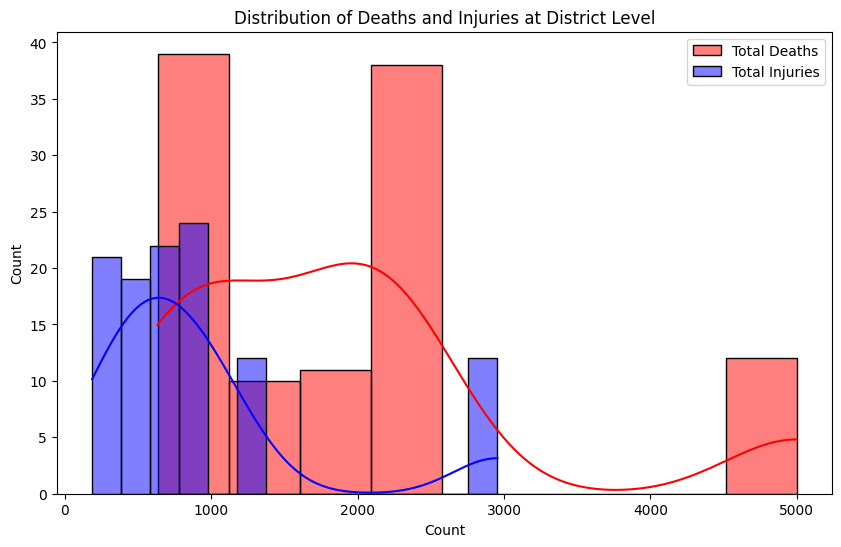

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(df['district_total_deaths'], kde=True, color='red', label='Total Deaths')
sns.histplot(df['district_total_injuries'], kde=True, color='blue', label='Total Injuries')
plt.title('Distribution of Deaths and Injuries at District Level')
plt.xlabel('Count')
plt.legend()
plt.show()

In [40]:
df.columns

Index(['vdcmun_id', 'district_id', 'vdcmun_name', 'district_name',
       'district_total_deaths', 'district_total_injuries',
       'district_death_cases', 'district_injury_cases', 'vdcmun_total_deaths',
       'vdcmun_total_injuries', 'vdcmun_death_cases', 'vdcmun_injury_cases',
       'district_population', 'vdcmun_population', 'district_deaths_per_1000',
       'district_injuries_per_1000', 'vdcmun_deaths_per_1000',
       'vdcmun_injuries_per_1000', 'district_geotechnical_risk_count',
       'vdcmun_geotechnical_risk_count', 'district_land_settlement_risk',
       'vdcmun_land_settlement_risk', 'district_fault_crack_risk',
       'vdcmun_fault_crack_risk', 'district_liquefaction_risk',
       'vdcmun_liquefaction_risk', 'district_landslide_risk',
       'vdcmun_landslide_risk', 'district_rock_fall_risk',
       'vdcmun_rock_fall_risk', 'district_flood_risk', 'vdcmun_flood_risk',
       'district_other_risk', 'vdcmun_other_risk'],
      dtype='object')

In [41]:
total_deaths_district = df['district_total_deaths'].sum()
total_injuries_district = df['district_total_injuries'].sum()
total_deaths_vdcmun = df['vdcmun_total_deaths'].sum()
total_injuries_vdcmun = df['vdcmun_total_injuries'].sum()

total_count_district_population = df['district_population'].sum()
total_count_vdcmun_population = df['vdcmun_population'].sum()

counts = [total_deaths_district, total_injuries_district]
district_injuries = df['district_injuries_per_1000']
district_deaths = df['district_deaths_per_1000']

vdcmun_injuries = df['vdcmun_injuries_per_1000']
vdcmun_deaths = df['vdcmun_deaths_per_1000']


In [42]:
df.head()

,vdcmun_id,district_id,vdcmun_name,district_name,district_total_deaths,district_total_injuries,district_death_cases,district_injury_cases,vdcmun_total_deaths,vdcmun_total_injuries,...,district_liquefaction_risk,vdcmun_liquefaction_risk,district_landslide_risk,vdcmun_landslide_risk,district_rock_fall_risk,vdcmun_rock_fall_risk,district_flood_risk,vdcmun_flood_risk,district_other_risk,vdcmun_other_risk
0,1201,12,Champadevi Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,82.0,31.0,...,211,1,2847,301,1448,89,356,0,23,0
1,1202,12,Chishankhu Gadhi Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,59.0,8.0,...,211,103,2847,298,1448,140,356,145,23,6
2,1203,12,Khiji Demba Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,101.0,48.0,...,211,23,2847,326,1448,279,356,2,23,4
3,1204,12,Likhu Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,69.0,20.0,...,211,23,2847,493,1448,202,356,12,23,2
4,1205,12,Manebhanjyang Rural Municipality,Okhaldhunga,634.0,187.0,613.0,185.0,42.0,12.0,...,211,41,2847,350,1448,117,356,88,23,1


In [43]:
# district wise deaths and injuries
dwd = {}
dwi = {}
# vdcmun wise deaths and injuries
vwd = {}
vwi = {}

for i in range(len(df)):
    dwd[df['district_name'][i]] = df['district_total_deaths'][i]
    dwi[df['district_name'][i]] = df['district_total_injuries'][i]
    vwd[df['vdcmun_name'][i]] = df['vdcmun_total_deaths'][i]
    vwi[df['vdcmun_name'][i]] = df['vdcmun_total_injuries'][i]

print(f"The dictionary of district wise deaths is: {dwd}")
print(f"The dictionary of district wise injuries is: {dwi}")
print(f"The dictionary of vdcmun wise deaths is: {vwd}")
print(f"The dictionary of vdcmun wise injuries is: {vwi}")





The dictionary of district wise deaths is: {'Okhaldhunga': 634.0, 'Sindhuli': 892.0, 'Ramechhap': 895.0, 'Dolakha': 961.0, 'Sindhupalchok': 4999.0, 'Kavrepalanchok': 2170.0, 'Nuwakot': 2451.0, 'Rasuwa': 790.0, 'Dhading': 2130.0, 'Makwanpur': 1526.0, 'Gorkha': 1757.0}
The dictionary of district wise injuries is: {'Okhaldhunga': 187.0, 'Sindhuli': 627.0, 'Ramechhap': 328.0, 'Dolakha': 493.0, 'Sindhupalchok': 2955.0, 'Kavrepalanchok': 695.0, 'Nuwakot': 1200.0, 'Rasuwa': 292.0, 'Dhading': 876.0, 'Makwanpur': 496.0, 'Gorkha': 968.0}
The dictionary of vdcmun wise deaths is: {'Champadevi Rural Municipality': 82.0, 'Chishankhu Gadhi Rural Municipality': 59.0, 'Khiji Demba Rural Municipality': 101.0, 'Likhu Rural Municipality': 132.0, 'Manebhanjyang Rural Municipality': 42.0, 'Molung Rural Municipality': 104.0, 'Siddhicharan Municipality': 124.0, 'Sunkoshi Rural Municipality': 196.0, 'Dudhouli Municipality': 247.0, 'Ghyanglekha Rural Municipality': 44.0, 'Golanjor Rural Municipality': 64.0, 'Ha

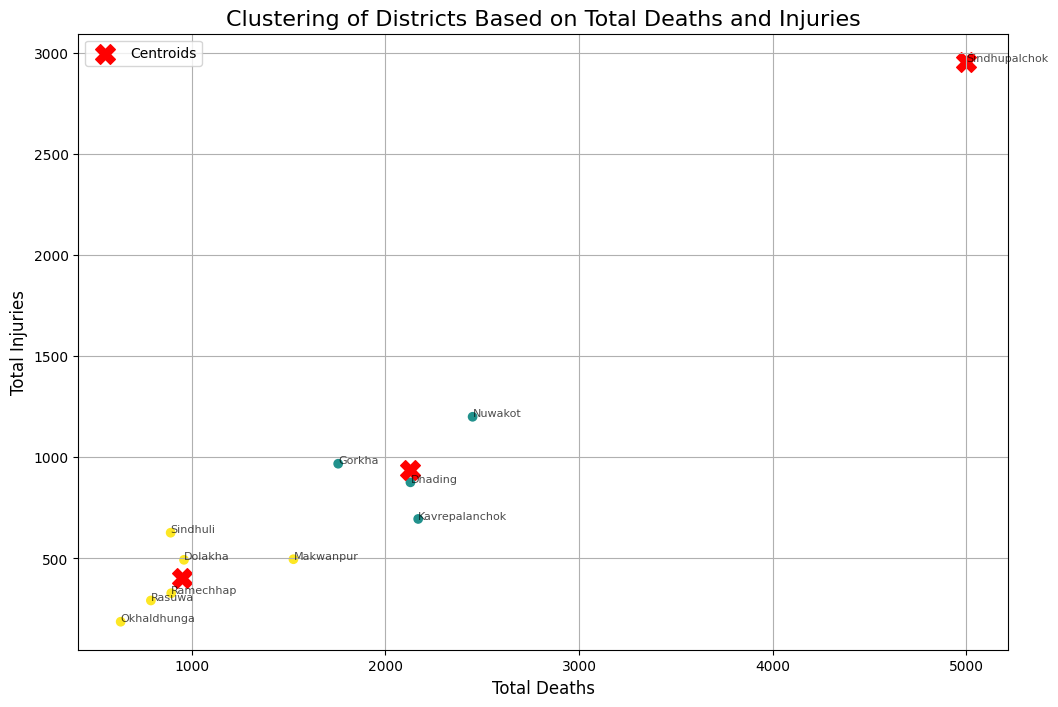

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the Data
# Create a DataFrame from the district-wise data
district_data = {
    'District': list(dwd.keys()),
    'Total_Deaths': list(dwd.values()),
    'Total_Injuries': list(dwi.values())
}
district_df = pd.DataFrame(district_data)

# Step 2: Normalize the Data
scaler = StandardScaler()
X = scaler.fit_transform(district_df[['Total_Deaths', 'Total_Injuries']])

# Step 3: Perform K-means Clustering
# Set the number of clusters
num_clusters = 3  # You can adjust this based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
district_df['Cluster'] = kmeans.fit_predict(X)

# Step 4: Visualize the Clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(district_df['Total_Deaths'], district_df['Total_Injuries'],
                      c=district_df['Cluster'], cmap='viridis', marker='o')

# Add cluster centers to the plot
centers = kmeans.cluster_centers_
scaled_centers = scaler.inverse_transform(centers)

# Plot cluster centers
plt.scatter(scaled_centers[:, 0], scaled_centers[:, 1], s=200, c='red', label='Centroids', marker='X')

# Add annotations
for i in range(len(district_df)):
    plt.annotate(district_df['District'][i], (district_df['Total_Deaths'][i], district_df['Total_Injuries'][i]),
                 fontsize=8, alpha=0.7)

plt.title('Clustering of Districts Based on Total Deaths and Injuries', fontsize=16)
plt.xlabel('Total Deaths', fontsize=12)
plt.ylabel('Total Injuries', fontsize=12)
plt.legend()
plt.grid()
plt.show()


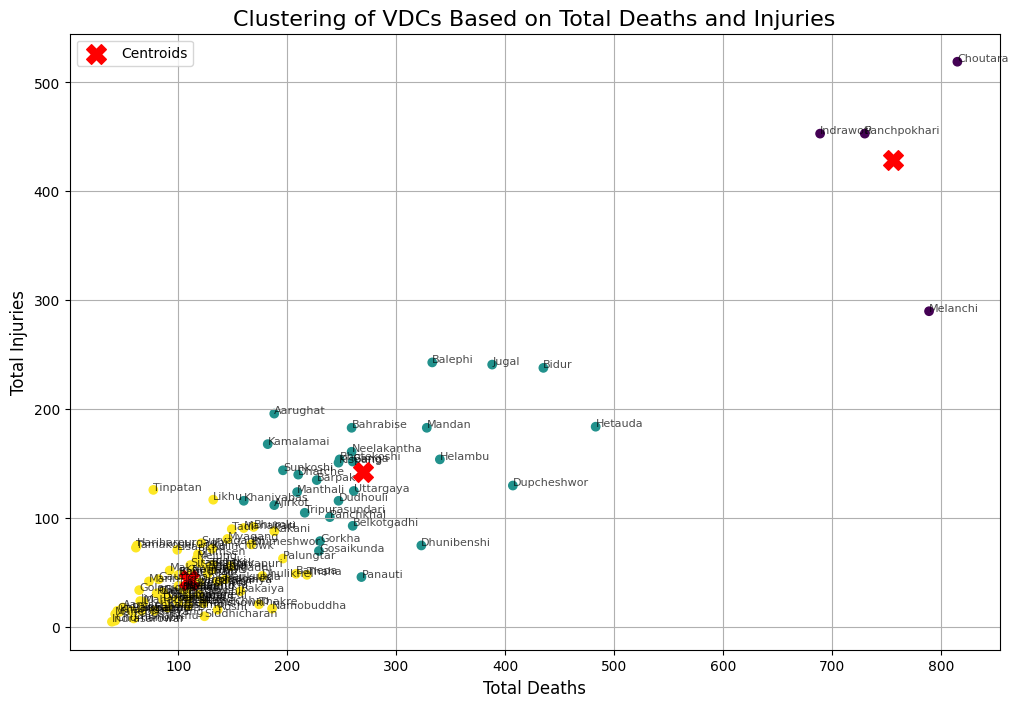

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the Data for VDCs
# Create a DataFrame from the VDC-wise data
vdc_data = {
    'VDC': list(vwd.keys()),
    'Total_Deaths': list(vwd.values()),
    'Total_Injuries': list(vwi.values())
}
vdc_df = pd.DataFrame(vdc_data)

# Step 2: Normalize the Data
scaler = StandardScaler()
X_vdc = scaler.fit_transform(vdc_df[['Total_Deaths', 'Total_Injuries']])

# Step 3: Perform K-means Clustering
# Set the number of clusters
num_clusters_vdc = 3  # You can adjust this based on your needs
kmeans_vdc = KMeans(n_clusters=num_clusters_vdc, random_state=42)
vdc_df['Cluster'] = kmeans_vdc.fit_predict(X_vdc)

# Step 4: Visualize the Clusters
plt.figure(figsize=(12, 8))
scatter_vdc = plt.scatter(vdc_df['Total_Deaths'], vdc_df['Total_Injuries'],
                           c=vdc_df['Cluster'], cmap='viridis', marker='o')

# Add cluster centers to the plot
centers_vdc = kmeans_vdc.cluster_centers_
scaled_centers_vdc = scaler.inverse_transform(centers_vdc)

# Plot cluster centers
plt.scatter(scaled_centers_vdc[:, 0], scaled_centers_vdc[:, 1], s=200, c='red', label='Centroids', marker='X')

# Add annotations with only the first word of VDC names
for i in range(len(vdc_df)):
    first_word = vdc_df['VDC'][i].split()[0]  # Get the first word of the VDC name
    plt.annotate(first_word, (vdc_df['Total_Deaths'][i], vdc_df['Total_Injuries'][i]),
                 fontsize=8, alpha=0.7)

plt.title('Clustering of VDCs Based on Total Deaths and Injuries', fontsize=16)
plt.xlabel('Total Deaths', fontsize=12)
plt.ylabel('Total Injuries', fontsize=12)
plt.legend()
plt.grid()
plt.show()


In [46]:
# vdc in district
# make a dictionary which has district name as key and list of vdc as value
dvd = {}
for i in range(len(df)):
    if df['district_name'][i] not in dvd:
        dvd[df['district_name'][i]] = [df['vdcmun_name'][i]]
    else:
        dvd[df['district_name'][i]].append(df['vdcmun_name'][i])
print(f"List of VDCs in each district is: {dvd}")

List of VDCs in each district is: {'Okhaldhunga': ['Champadevi Rural Municipality', 'Chishankhu Gadhi Rural Municipality', 'Khiji Demba Rural Municipality', 'Likhu Rural Municipality', 'Manebhanjyang Rural Municipality', 'Molung Rural Municipality', 'Siddhicharan Municipality', 'Sunkoshi Rural Municipality'], 'Sindhuli': ['Dudhouli Municipality', 'Ghyanglekha Rural Municipality', 'Golanjor Rural Municipality', 'Hariharpurgaghi Rural Municipality', 'Kamalamai Municipality', 'Marin Rural Municipality', 'Phikkal Rural Municipality', 'Sunkoshi Rural Municipality', 'Tinpatan Rural Municipality'], 'Ramechhap': ['Doramba Rural Municipality', 'Gokulganga Rural Municipality', 'Khandadevi Rural Municipality', 'Likhu Tamakoshi Rural Municipality', 'Manthali  Municipality', 'Ramechhap Municipality', 'Sunapati Rural Municipality', 'Umakunda Rural Municipality'], 'Dolakha': ['Baitedhar Rural Municipality', 'Bhimeshwor Municipality', 'Bigu Rural Municipality', 'Gaurishankar Rural Municipality', 'Jiri

In [47]:
# Step 1: Create a dictionary to hold districts and their VDCs
dvd = {}
for i in range(len(df)):
    if df['district_name'][i] not in dvd:
        dvd[df['district_name'][i]] = [df['vdcmun_name'][i]]
    else:
        dvd[df['district_name'][i]].append(df['vdcmun_name'][i])

# Print the list of VDCs in each district
print(f"List of VDCs in each district is: {dvd}")

# Step 2: Prepare to compare VDC clustering results
# Add cluster information to the dictionary
vdc_cluster_info = {}
for i in range(len(vdc_df)):
    district = df['district_name'][df['vdcmun_name'] == vdc_df['VDC'][i]].values[0]
    cluster = vdc_df['Cluster'][i]

    if district not in vdc_cluster_info:
        vdc_cluster_info[district] = {'VDCs': [], 'Clusters': []}

    vdc_cluster_info[district]['VDCs'].append(vdc_df['VDC'][i])
    vdc_cluster_info[district]['Clusters'].append(cluster)

# Print clustering results for VDCs within each district
for district, info in vdc_cluster_info.items():
    print(f"\nDistrict: {district}")
    for vdc, cluster in zip(info['VDCs'], info['Clusters']):
        print(f"  VDC: {vdc}, Cluster: {cluster}")


List of VDCs in each district is: {'Okhaldhunga': ['Champadevi Rural Municipality', 'Chishankhu Gadhi Rural Municipality', 'Khiji Demba Rural Municipality', 'Likhu Rural Municipality', 'Manebhanjyang Rural Municipality', 'Molung Rural Municipality', 'Siddhicharan Municipality', 'Sunkoshi Rural Municipality'], 'Sindhuli': ['Dudhouli Municipality', 'Ghyanglekha Rural Municipality', 'Golanjor Rural Municipality', 'Hariharpurgaghi Rural Municipality', 'Kamalamai Municipality', 'Marin Rural Municipality', 'Phikkal Rural Municipality', 'Sunkoshi Rural Municipality', 'Tinpatan Rural Municipality'], 'Ramechhap': ['Doramba Rural Municipality', 'Gokulganga Rural Municipality', 'Khandadevi Rural Municipality', 'Likhu Tamakoshi Rural Municipality', 'Manthali  Municipality', 'Ramechhap Municipality', 'Sunapati Rural Municipality', 'Umakunda Rural Municipality'], 'Dolakha': ['Baitedhar Rural Municipality', 'Bhimeshwor Municipality', 'Bigu Rural Municipality', 'Gaurishankar Rural Municipality', 'Jiri

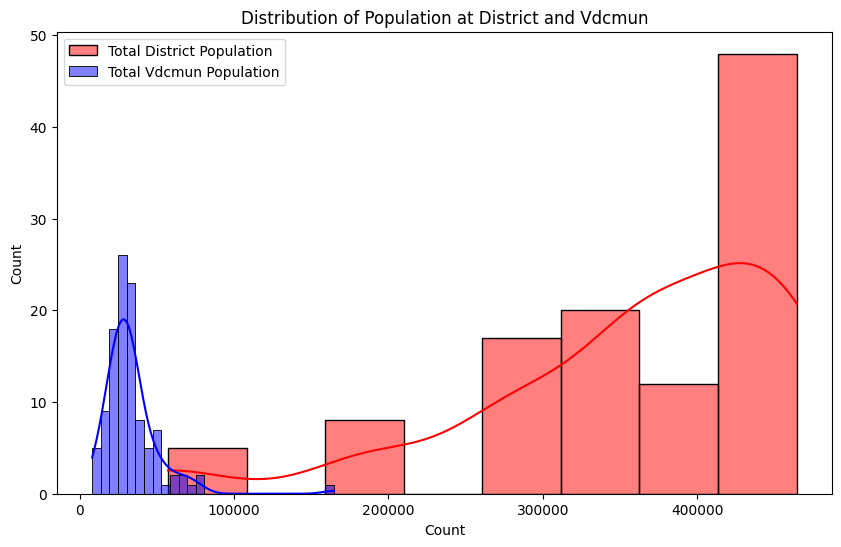

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(df['district_population'], kde=True, color='red', label='Total District Population')
sns.histplot(df['vdcmun_population'], kde=True, color='blue', label='Total Vdcmun Population')
plt.title('Distribution of Population at District and Vdcmun')
plt.xlabel('Count')
plt.legend()
plt.show()

C:\Users\offic\AppData\Local\Temp\ipykernel_6664\131258828.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Count', data=total_counts_df, ax=ax1, palette='viridis')
C:\Users\offic\AppData\Local\Temp\ipykernel_6664\131258828.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(total_counts_df['Category'], rotation=15)


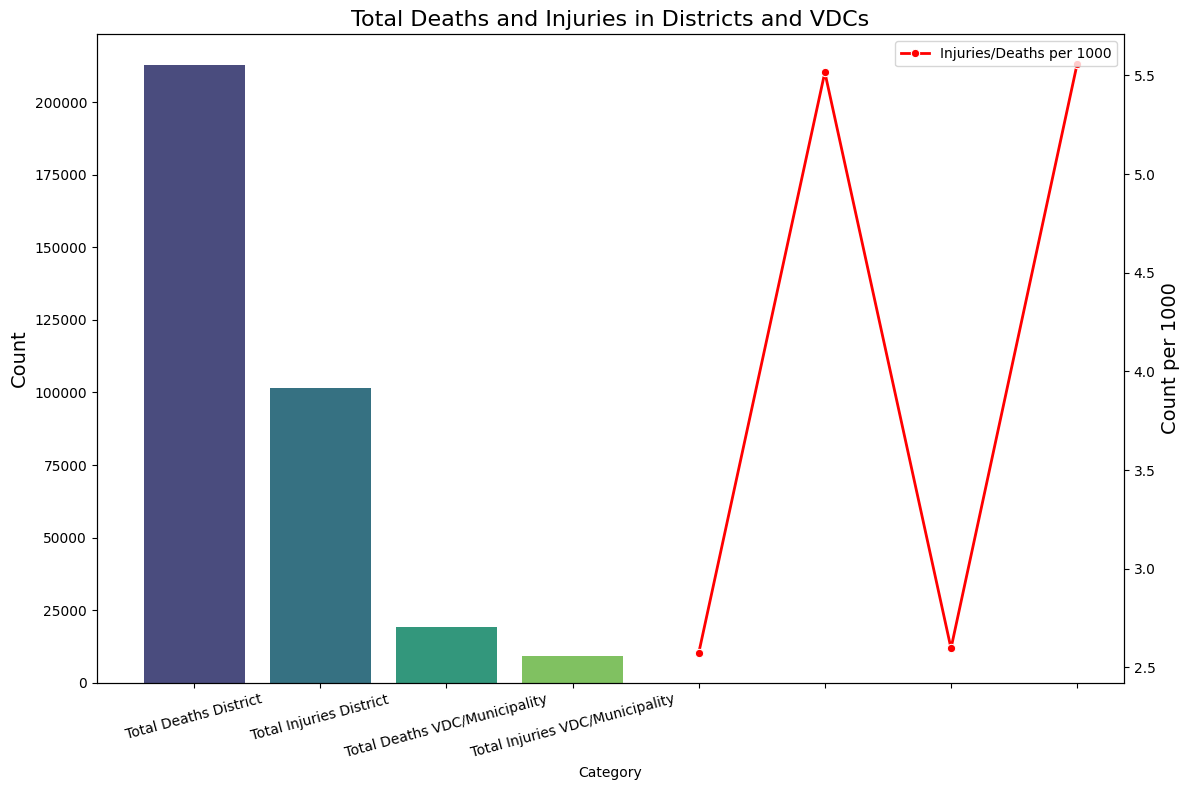

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Total counts
total_deaths_district = df['district_total_deaths'].sum()
total_injuries_district = df['district_total_injuries'].sum()
total_deaths_vdcmun = df['vdcmun_total_deaths'].sum()
total_injuries_vdcmun = df['vdcmun_total_injuries'].sum()

# Data for total counts
total_counts = {
    'Category': ['Total Deaths District', 'Total Injuries District',
                 'Total Deaths VDC/Municipality', 'Total Injuries VDC/Municipality'],
    'Count': [total_deaths_district, total_injuries_district,
              total_deaths_vdcmun, total_injuries_vdcmun]
}

# Create DataFrame for total counts
total_counts_df = pd.DataFrame(total_counts)

# Set up the figure
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create a bar plot for total counts
sns.barplot(x='Category', y='Count', data=total_counts_df, ax=ax1, palette='viridis')
ax1.set_title('Total Deaths and Injuries in Districts and VDCs', fontsize=16)
ax1.set_ylabel('Count', fontsize=14)
ax1.set_xticklabels(total_counts_df['Category'], rotation=15)

# Add a secondary y-axis for per-thousand metrics
ax2 = ax1.twinx()

# Data for per-thousand metrics
district_injuries = df['district_injuries_per_1000'].mean()
district_deaths = df['district_deaths_per_1000'].mean()
vdcmun_injuries = df['vdcmun_injuries_per_1000'].mean()
vdcmun_deaths = df['vdcmun_deaths_per_1000'].mean()

# Data for per-thousand metrics
per_thousand_counts = {
    'Category': ['District Injuries per 1000', 'District Deaths per 1000',
                 'VDC Injuries per 1000', 'VDC Deaths per 1000'],
    'Count': [district_injuries, district_deaths, vdcmun_injuries, vdcmun_deaths]
}

# Create DataFrame for per-thousand counts
per_thousand_counts_df = pd.DataFrame(per_thousand_counts)

# Create a line plot for per-thousand metrics
sns.lineplot(x='Category', y='Count', data=per_thousand_counts_df,
             ax=ax2, color='red', marker='o', linewidth=2, label='Injuries/Deaths per 1000')

ax2.set_ylabel('Count per 1000', fontsize=14)
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


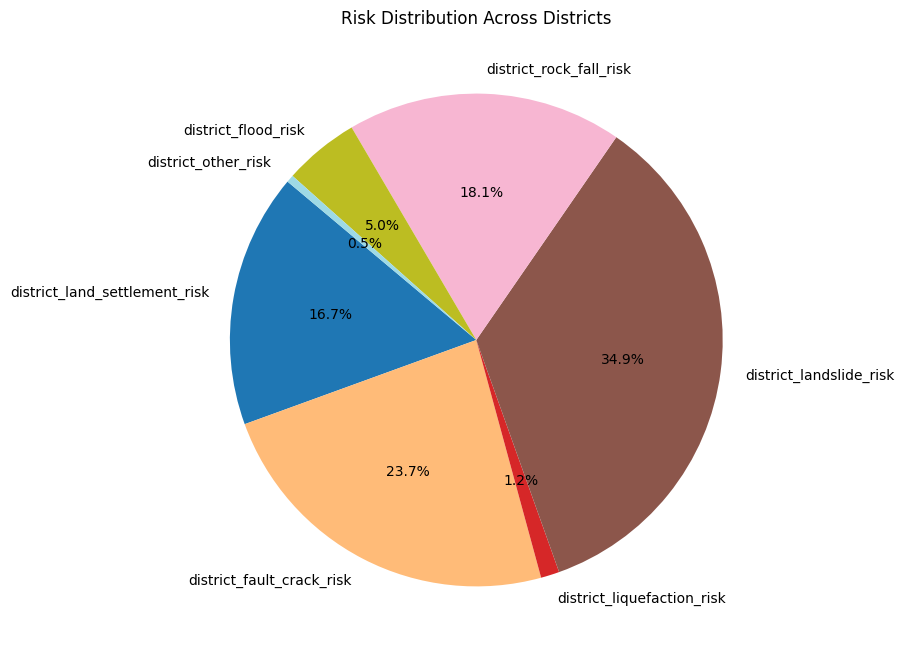

In [50]:
risk_sums = df[['district_land_settlement_risk', 'district_fault_crack_risk',
                'district_liquefaction_risk', 'district_landslide_risk',
                'district_rock_fall_risk', 'district_flood_risk',
                'district_other_risk']].sum()

# Pie chart
plt.figure(figsize=(8, 8))
risk_sums.plot(kind='pie', autopct='%1.1f%%', startangle=140, cmap='tab20')
plt.title('Risk Distribution Across Districts')
plt.ylabel('')
plt.show()

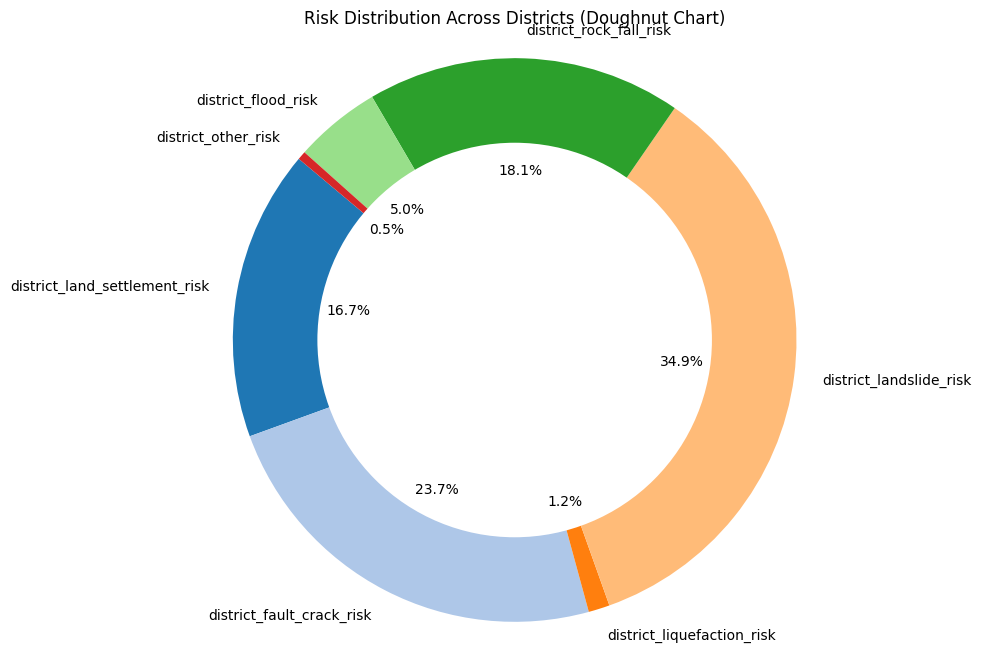

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with your actual DataFrame)
# df = pd.read_csv('your_data.csv')

# Calculate the risk sums
risk_sums = df[['district_land_settlement_risk', 'district_fault_crack_risk',
                'district_liquefaction_risk', 'district_landslide_risk',
                'district_rock_fall_risk', 'district_flood_risk',
                'district_other_risk']].sum()

# Doughnut chart
plt.figure(figsize=(8, 8))
plt.pie(risk_sums, labels=risk_sums.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')  # Create a white circle at the center
fig = plt.gcf()
fig.gca().add_artist(centre_circle)  # Add the circle to the pie chart
plt.title('Risk Distribution Across Districts (Doughnut Chart)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


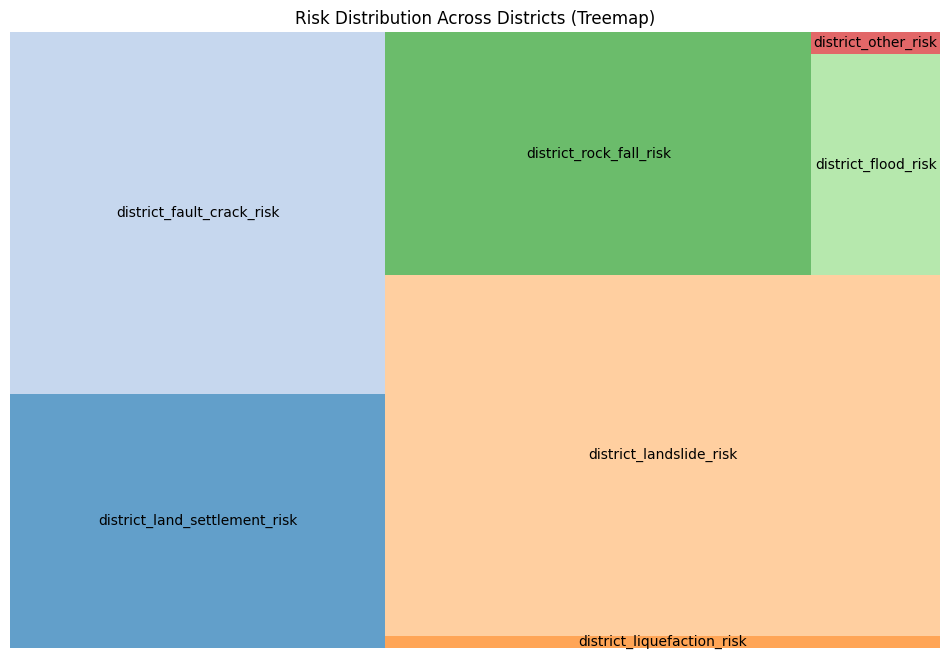

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify

# Sample DataFrame (replace with your actual DataFrame)
# df = pd.read_csv('your_data.csv')

# Calculate the risk sums
risk_sums = df[['district_land_settlement_risk', 'district_fault_crack_risk',
                'district_liquefaction_risk', 'district_landslide_risk',
                'district_rock_fall_risk', 'district_flood_risk',
                'district_other_risk']].sum()

# Create a treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=risk_sums, label=risk_sums.index, color=plt.cm.tab20.colors, alpha=0.7)
plt.title('Risk Distribution Across Districts (Treemap)')
plt.axis('off')  # Turn off the axis
plt.show()


In [53]:
import pandas as pd
import plotly.express as px

# Sample DataFrame (replace with your actual DataFrame)
# df = pd.read_csv('your_data.csv')

# Prepare data for the sunburst chart
# Melt the risk data to long format
risk_data = df[['district_name', 'district_land_settlement_risk', 'district_fault_crack_risk',
                 'district_liquefaction_risk', 'district_landslide_risk',
                 'district_rock_fall_risk', 'district_flood_risk',
                 'district_other_risk']]

# Melt the DataFrame to get a long format suitable for the sunburst chart
risk_data_melted = risk_data.melt(id_vars='district_name',
                                    var_name='risk_type',
                                    value_name='risk_value')

# Create the sunburst chart
fig = px.sunburst(risk_data_melted,
                  path=['district_name', 'risk_type'],
                  values='risk_value',
                  title='Sunburst Chart of Risk Distribution Across Districts')

# Update layout for size and text clarity
fig.update_layout(
    width=1600,  # Adjust the width as needed
    height=1200,  # Adjust the height as needed
    title_font=dict(size=24),  # Adjust title font size
    font=dict(size=14)  # Adjust font size for the text
)

# Show the figure
fig.show()


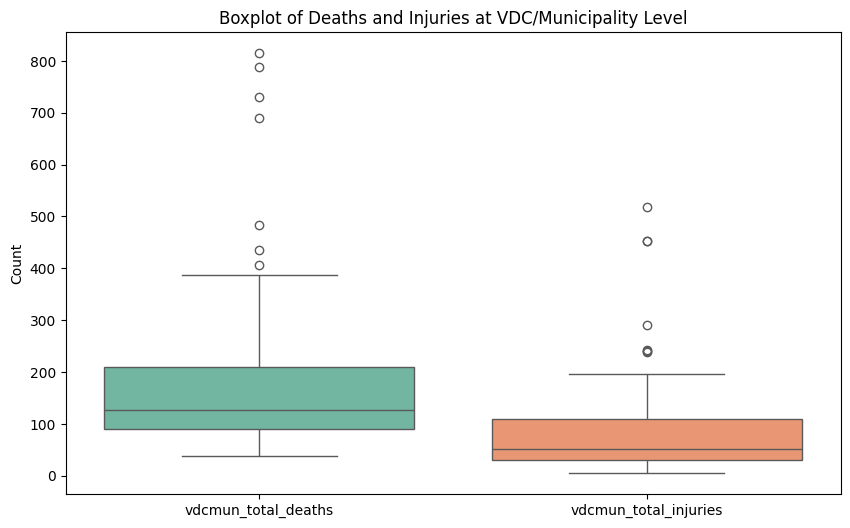

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['vdcmun_total_deaths', 'vdcmun_total_injuries']], palette='Set2')
plt.title('Boxplot of Deaths and Injuries at VDC/Municipality Level')
plt.ylabel('Count')
plt.show()

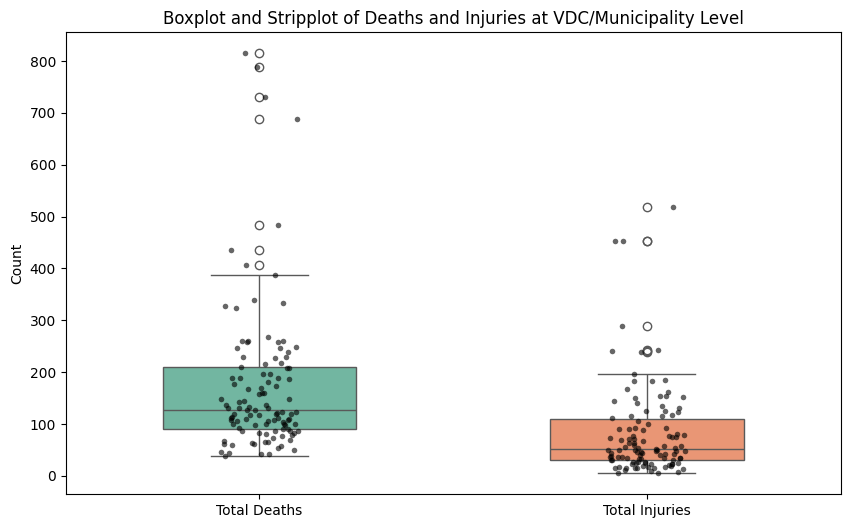

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame (replace with your actual DataFrame)
# df = pd.read_csv('your_data.csv')

# Create a combined boxplot and stripplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['vdcmun_total_deaths', 'vdcmun_total_injuries']], palette='Set2', width=0.5)
sns.stripplot(data=df[['vdcmun_total_deaths', 'vdcmun_total_injuries']], color='black', alpha=0.6, size=4, jitter=True)
plt.title('Boxplot and Stripplot of Deaths and Injuries at VDC/Municipality Level')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Total Deaths', 'Total Injuries'])
plt.show()


C:\Users\offic\AppData\Local\Temp\ipykernel_6664\1112763119.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




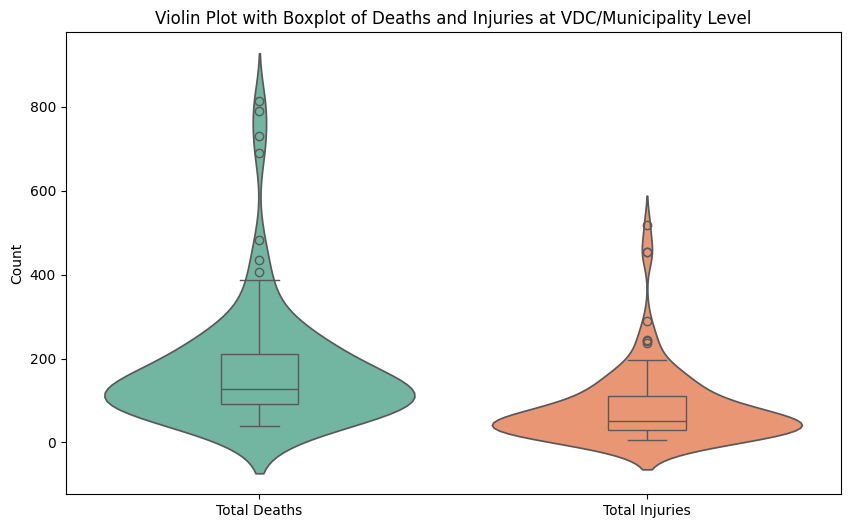

In [56]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df[['vdcmun_total_deaths', 'vdcmun_total_injuries']], palette='Set2', inner=None)
sns.boxplot(data=df[['vdcmun_total_deaths', 'vdcmun_total_injuries']], palette='Set2', width=0.2, color='white')
plt.title('Violin Plot with Boxplot of Deaths and Injuries at VDC/Municipality Level')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Total Deaths', 'Total Injuries'])
plt.show()


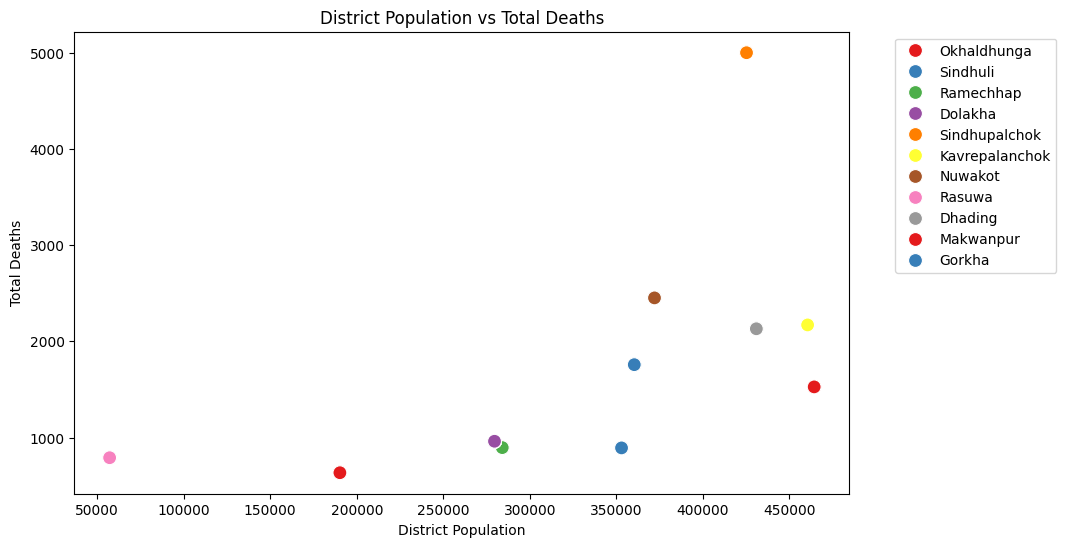

In [57]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='district_population', y='district_total_deaths', data=df, hue='district_name', palette='Set1', s=100)
plt.title('District Population vs Total Deaths')
plt.xlabel('District Population')
plt.ylabel('Total Deaths')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


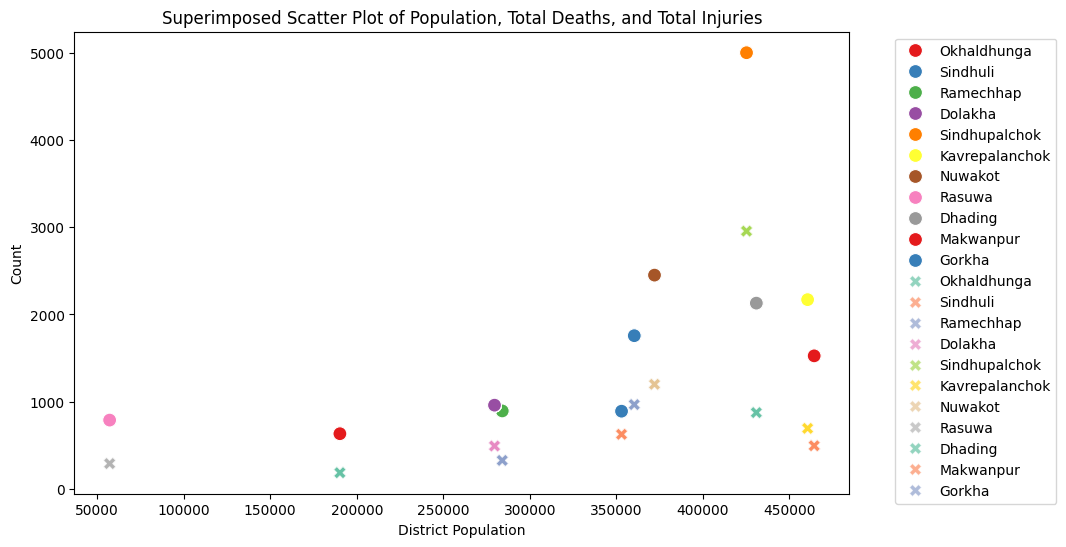

In [58]:
plt.figure(figsize=(10, 6))

# Scatter plot for Total Deaths
sns.scatterplot(x='district_population', y='district_total_deaths',
                data=df, hue='district_name', palette='Set1',
                s=100, marker='o', edgecolor='w')

# Overlay scatter plot for total injuries
sns.scatterplot(x='district_population', y='district_total_injuries',
                data=df, hue='district_name', palette='Set2',
                s=80, marker='X', alpha=0.7)

plt.title('Superimposed Scatter Plot of Population, Total Deaths, and Total Injuries')
plt.xlabel('District Population')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


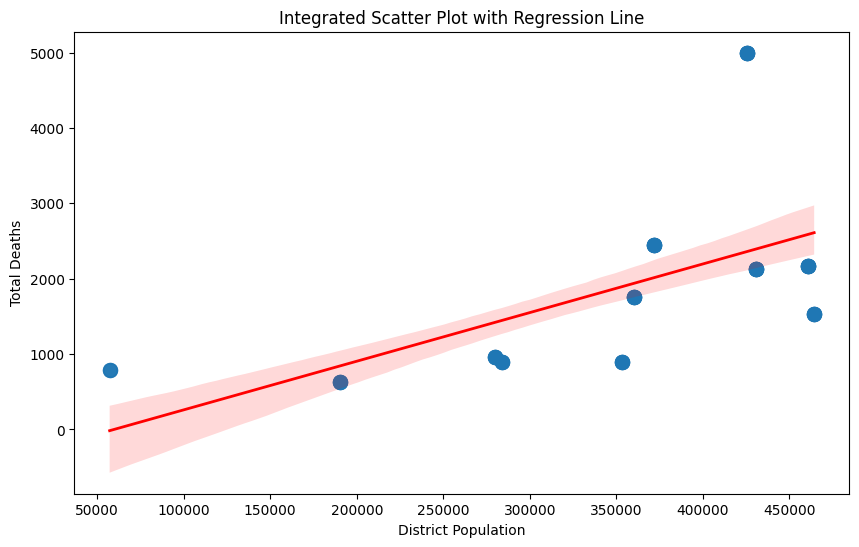

In [59]:
plt.figure(figsize=(10, 6))
sns.regplot(x='district_population', y='district_total_deaths',
            data=df, scatter_kws={'s': 100, 'alpha': 0.5},
            line_kws={'color': 'red', 'linewidth': 2})

plt.title('Integrated Scatter Plot with Regression Line')
plt.xlabel('District Population')
plt.ylabel('Total Deaths')
plt.show()


C:\Users\offic\AppData\Local\Temp\ipykernel_6664\2599470408.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




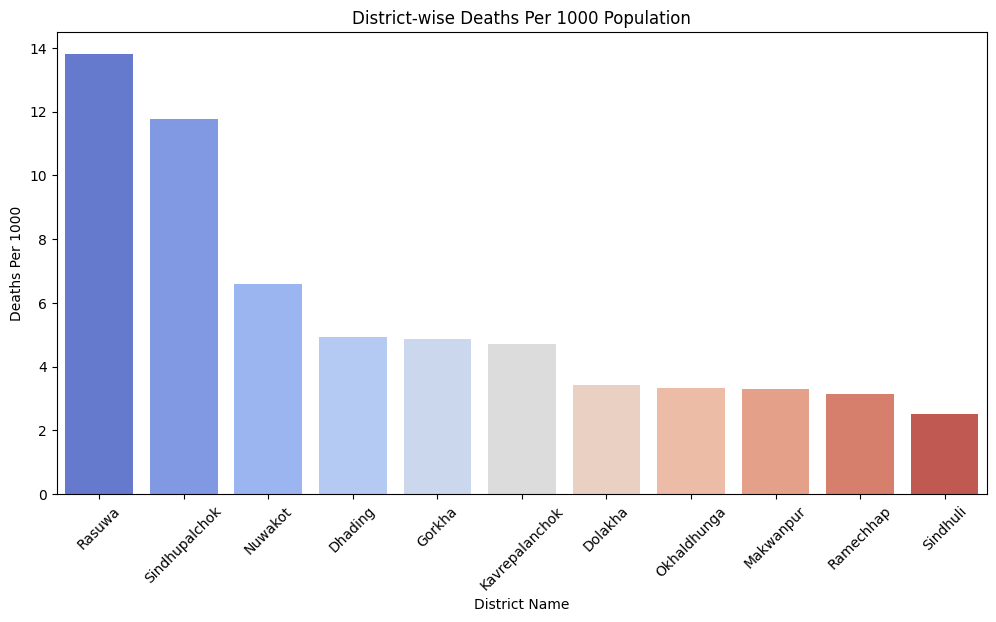

In [60]:
plt.figure(figsize=(12, 6))
df_sorted = df.sort_values(by='district_deaths_per_1000', ascending=False)
sns.barplot(x='district_name', y='district_deaths_per_1000', data=df_sorted, palette='coolwarm')
plt.title('District-wise Deaths Per 1000 Population')
plt.xlabel('District Name')
plt.ylabel('Deaths Per 1000')
plt.xticks(rotation=45)
plt.show()

C:\Users\offic\AppData\Local\Temp\ipykernel_6664\3343614097.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




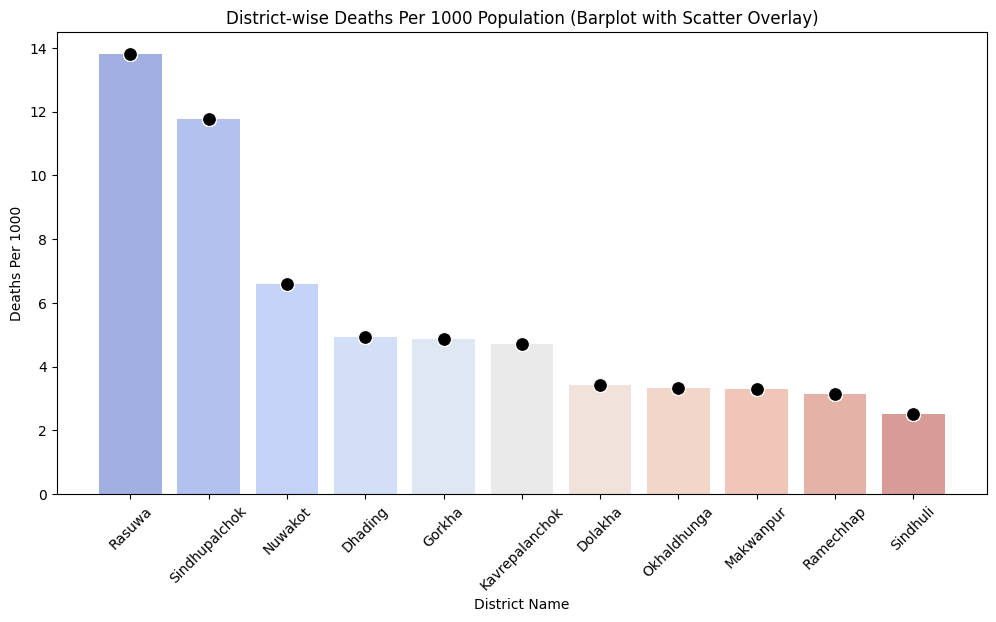

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame (replace with your actual DataFrame)
# df = pd.read_csv('your_data.csv')

# Sort the DataFrame for the bar plot
df_sorted = df.sort_values(by='district_deaths_per_1000', ascending=False)

# Create a barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='district_name', y='district_deaths_per_1000', data=df_sorted, palette='coolwarm', alpha=0.6)

# Overlay a scatter plot
sns.scatterplot(x='district_name', y='district_deaths_per_1000', data=df_sorted, color='black', s=100, edgecolor='w')

plt.title('District-wise Deaths Per 1000 Population (Barplot with Scatter Overlay)')
plt.xlabel('District Name')
plt.ylabel('Deaths Per 1000')
plt.xticks(rotation=45)
plt.show()


C:\Users\offic\AppData\Local\Temp\ipykernel_6664\167590905.py:14: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



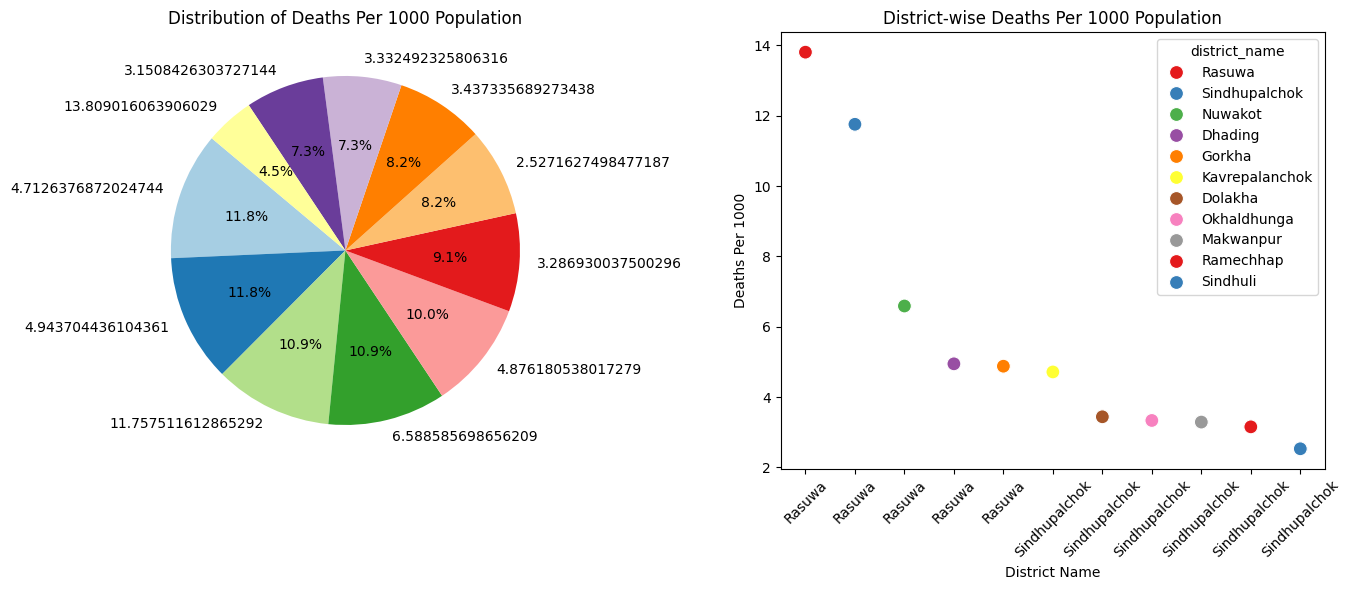

In [62]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart for total deaths distribution
total_deaths_distribution = df['district_deaths_per_1000'].value_counts()
axes[0].pie(total_deaths_distribution, labels=total_deaths_distribution.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
axes[0].set_title('Distribution of Deaths Per 1000 Population')

# Scatter plot for deaths per 1000 population
sns.scatterplot(x='district_name', y='district_deaths_per_1000', data=df_sorted, hue='district_name', palette='Set1', s=100, ax=axes[1])
axes[1].set_title('District-wise Deaths Per 1000 Population')
axes[1].set_xlabel('District Name')
axes[1].set_ylabel('Deaths Per 1000')
axes[1].set_xticklabels(df_sorted['district_name'], rotation=45)

plt.tight_layout()
plt.show()


C:\Users\offic\AppData\Local\Temp\ipykernel_6664\2598533594.py:39: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



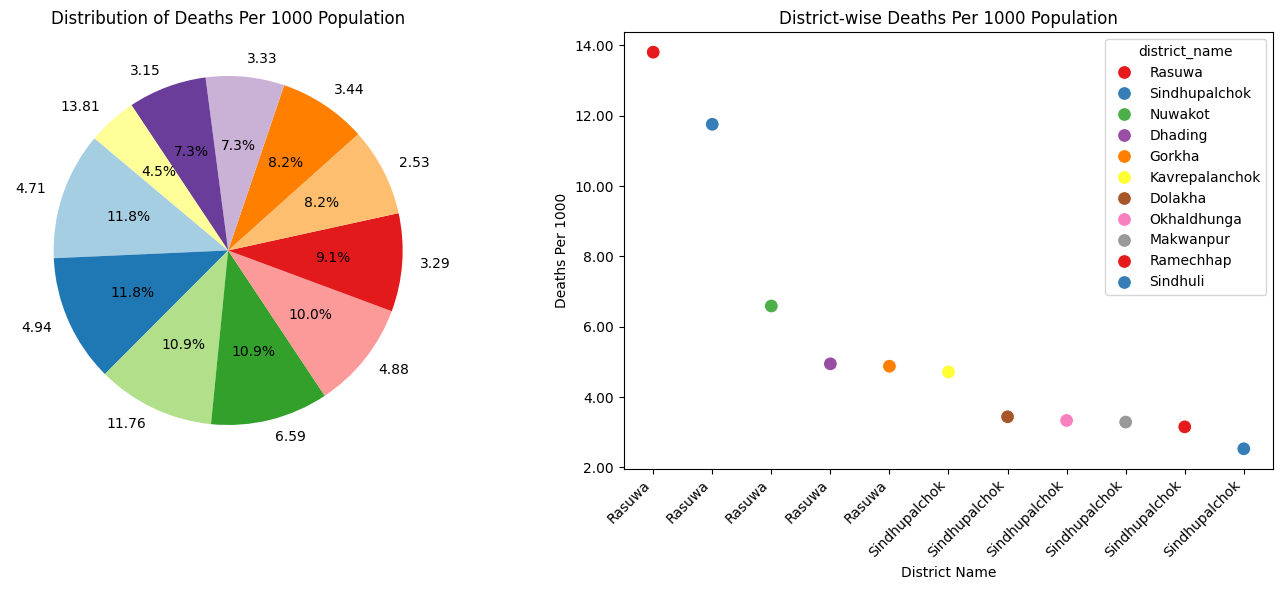

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df and df_sorted are defined
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart for total deaths distribution
total_deaths_distribution = df['district_deaths_per_1000'].value_counts()

# Format the labels with 2 decimal points
formatted_labels = [f'{label:.2f}' for label in total_deaths_distribution.index]
axes[0].pie(
    total_deaths_distribution,
    labels=formatted_labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
axes[0].set_title('Distribution of Deaths Per 1000 Population')

# Scatter plot for deaths per 1000 population
sns.scatterplot(
    x='district_name',
    y='district_deaths_per_1000',
    data=df_sorted,
    hue='district_name',
    palette='Set1',
    s=100,
    ax=axes[1]
)
axes[1].set_title('District-wise Deaths Per 1000 Population')
axes[1].set_xlabel('District Name')
axes[1].set_ylabel('Deaths Per 1000')

# Format y-axis values with 2 decimal points
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

# Adjust x-axis labels rotation for better readability
axes[1].set_xticklabels(df_sorted['district_name'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


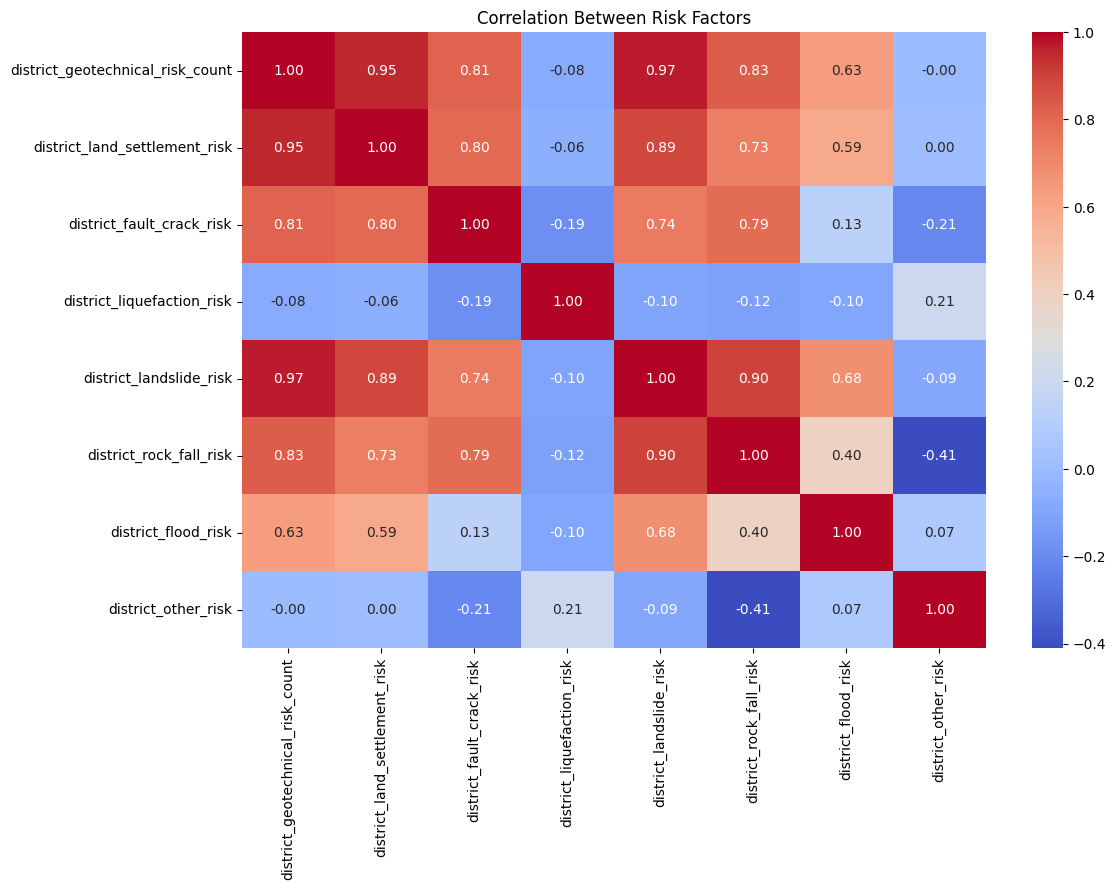

In [64]:
plt.figure(figsize=(12, 8))
risk_cols = ['district_geotechnical_risk_count', 'district_land_settlement_risk',
             'district_fault_crack_risk', 'district_liquefaction_risk',
             'district_landslide_risk', 'district_rock_fall_risk',
             'district_flood_risk', 'district_other_risk']
sns.heatmap(df[risk_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Risk Factors')
plt.show()


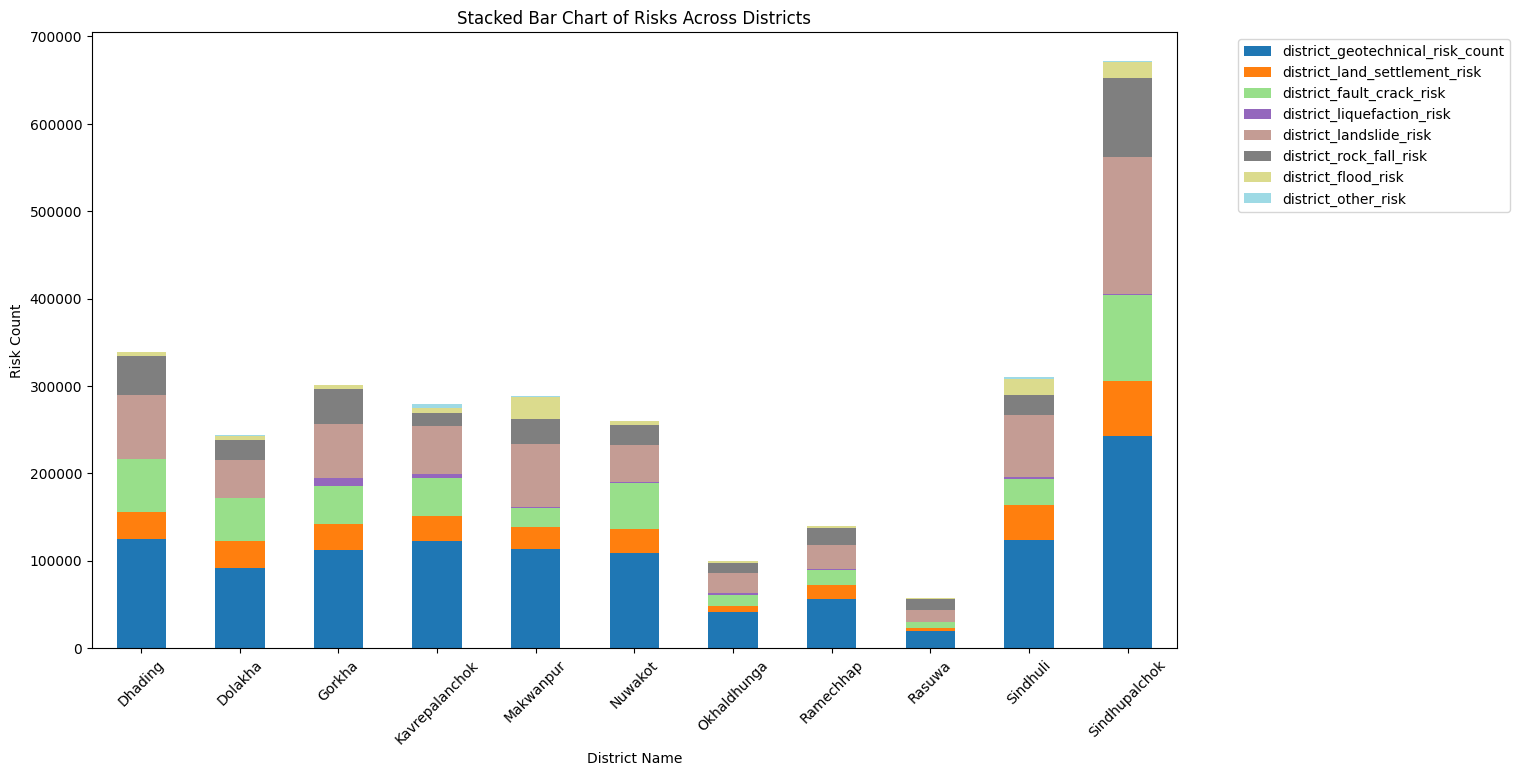

In [65]:
risk_counts = df.groupby('district_name')[risk_cols].sum()

risk_counts.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.title('Stacked Bar Chart of Risks Across Districts')
plt.ylabel('Risk Count')
plt.xlabel('District Name')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


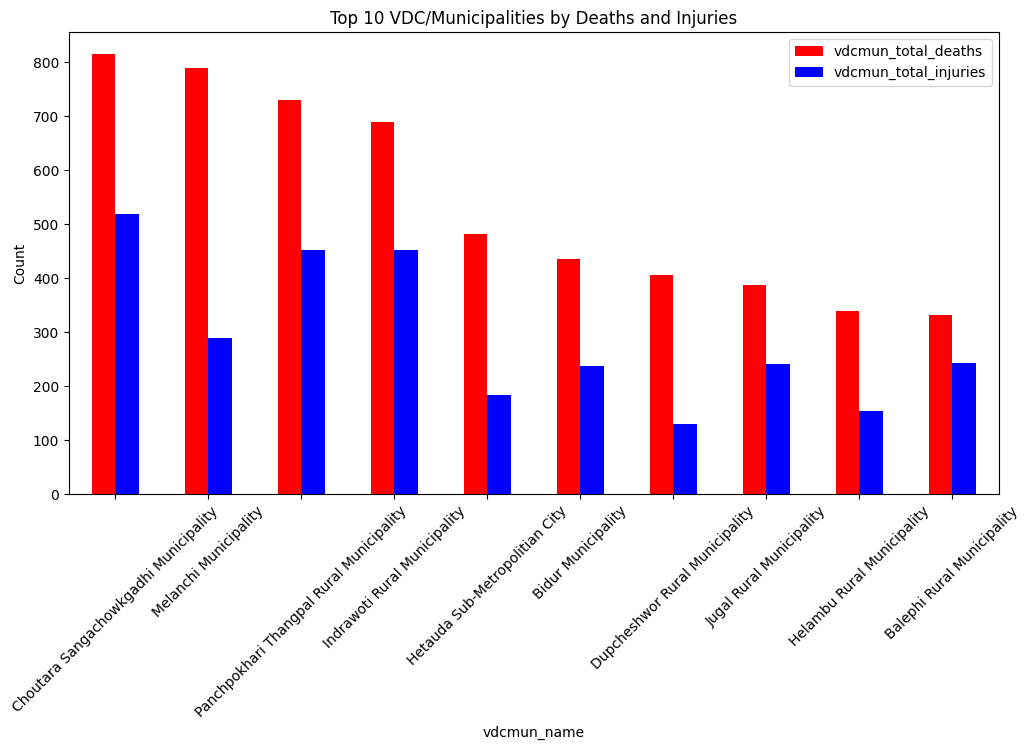

In [66]:
top_vdcmun = df.nlargest(10, 'vdcmun_total_deaths')

top_vdcmun.plot(x='vdcmun_name', y=['vdcmun_total_deaths', 'vdcmun_total_injuries'],
                kind='bar', figsize=(12, 6), color=['red', 'blue'])
plt.title('Top 10 VDC/Municipalities by Deaths and Injuries')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


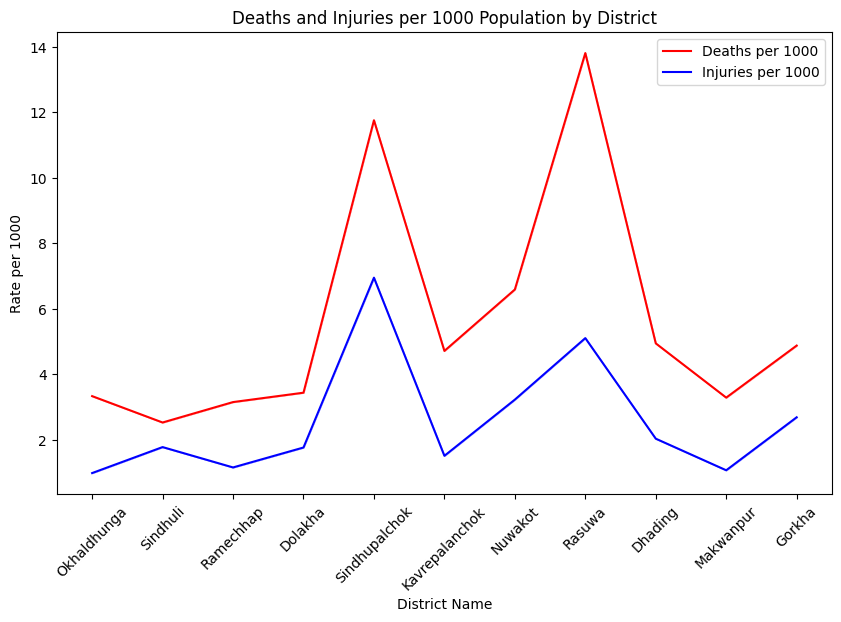

In [67]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='district_name', y='district_deaths_per_1000', label='Deaths per 1000', color='red')
sns.lineplot(data=df, x='district_name', y='district_injuries_per_1000', label='Injuries per 1000', color='blue')
plt.title('Deaths and Injuries per 1000 Population by District')
plt.xlabel('District Name')
plt.ylabel('Rate per 1000')
plt.xticks(rotation=45)
plt.legend()
plt.show()


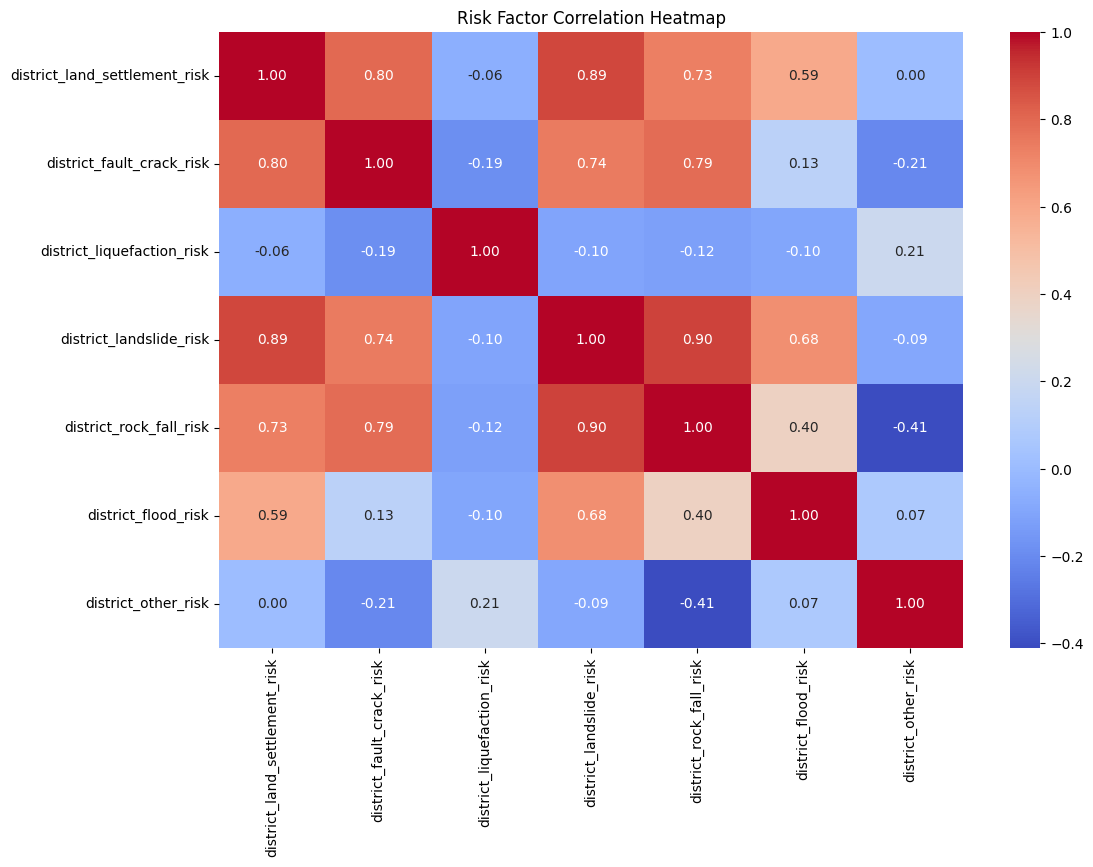

In [68]:
# Filter risk data for heatmap
risk_cols = ['district_land_settlement_risk', 'district_fault_crack_risk',
             'district_liquefaction_risk', 'district_landslide_risk',
             'district_rock_fall_risk', 'district_flood_risk', 'district_other_risk']

plt.figure(figsize=(12, 8))
sns.heatmap(df[risk_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Risk Factor Correlation Heatmap')
plt.show()

In [69]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

# Extract correlation matrix
corr_matrix = df[risk_cols].corr()

# Filter only significant correlations (e.g., above 0.5 or below -0.5)
threshold = 0.5
significant_corr = corr_matrix.stack().reset_index()
significant_corr.columns = ['Factor1', 'Factor2', 'Correlation']
significant_corr = significant_corr[(abs(significant_corr['Correlation']) >= threshold) &
                                     (significant_corr['Factor1'] != significant_corr['Factor2'])]

# Prepare data for hierarchical plots
significant_corr['Category'] = significant_corr['Correlation'].apply(lambda x: 'Positive' if x > 0 else 'Negative')


In [70]:
fig_sunburst = px.sunburst(
    significant_corr,
    path=['Category', 'Factor1', 'Factor2'],
    values='Correlation',
    color='Correlation',
    color_continuous_scale='Viridis',
    title='Sunburst Chart of Significant Correlations',
    width=1600,
    height=1200,
)
fig_sunburst.show()


In [71]:
fig_pie = px.pie(
    significant_corr,
    names='Factor1',
    values='Correlation',
    title='Pie Chart of Correlations by Risk Factor',
    color_discrete_sequence=px.colors.qualitative.Set3
)
fig_pie.show()


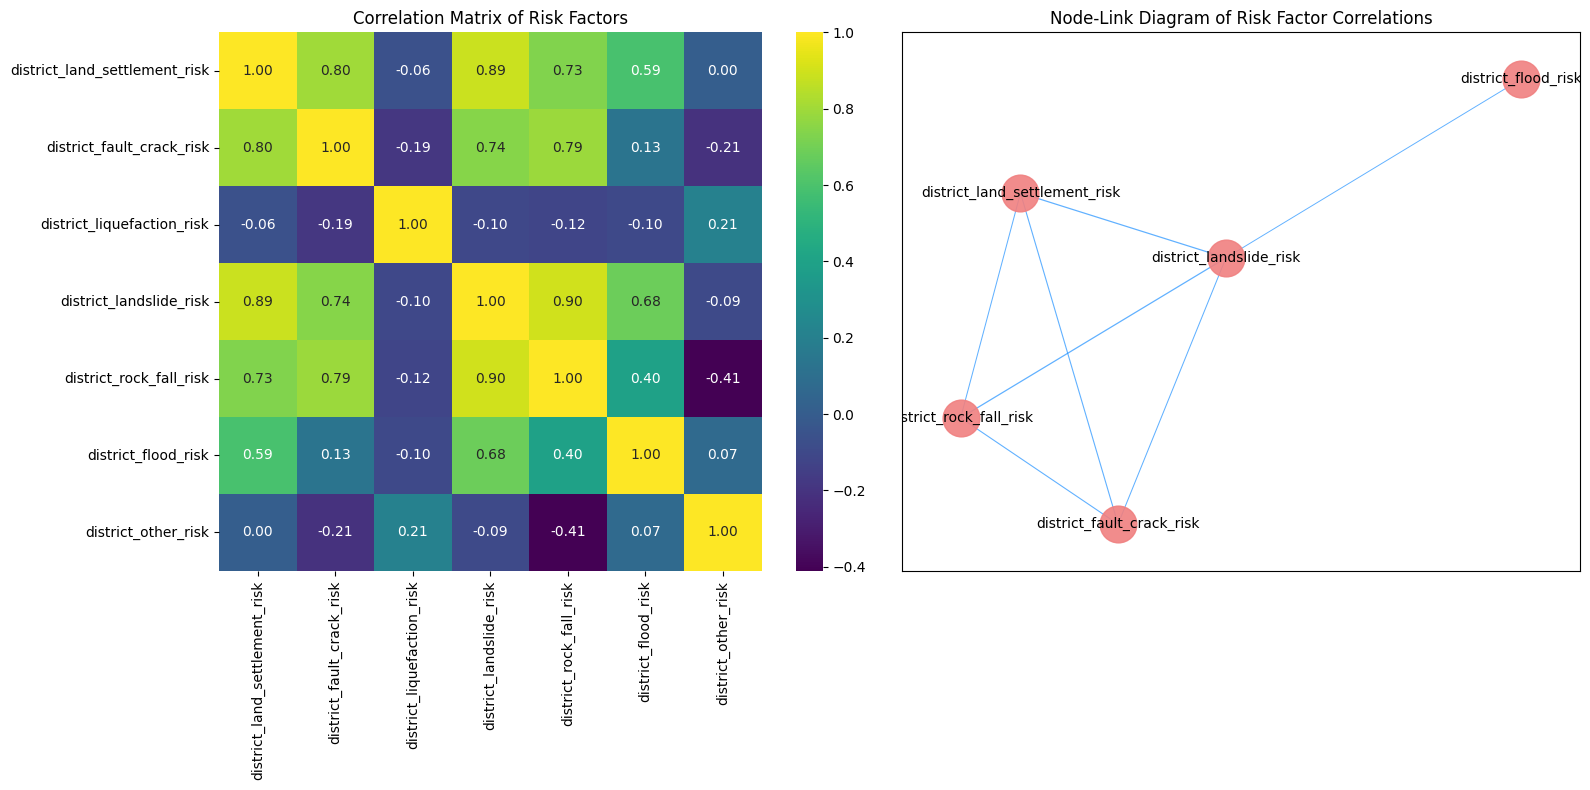

In [72]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare the correlation matrix
corr_matrix = df[risk_cols].corr()

# Create a graph from the correlation matrix
threshold = 0.6  # Only include correlations above this threshold
G = nx.Graph()

for i, col in enumerate(corr_matrix.columns):
    for j, val in enumerate(corr_matrix.iloc[i]):
        if i != j and abs(val) > threshold:
            G.add_edge(corr_matrix.index[i], corr_matrix.columns[j], weight=val)

# Plotting the correlation matrix and node-link diagram side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Heatmap for correlation matrix with a different color scheme
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', ax=axes[0])  # Changed cmap to 'viridis'
axes[0].set_title('Correlation Matrix of Risk Factors')

# Node-link diagram with a different color scheme
pos = nx.spring_layout(G, seed=42)  # Layout for the network graph
edges = G.edges(data=True)

# Draw nodes with a different color and size
node_color = 'lightcoral'  # Change node color
nx.draw_networkx_nodes(G, pos, ax=axes[1], node_size=700, node_color=node_color, alpha=0.9)

# Draw edges with a different color and style
edge_color = 'dodgerblue'  # Change edge color
nx.draw_networkx_edges(G, pos, ax=axes[1], width=[d['weight'] for u, v, d in edges], alpha=0.7, edge_color=edge_color)

# Draw labels
nx.draw_networkx_labels(G, pos, ax=axes[1], font_size=10)

axes[1].set_title('Node-Link Diagram of Risk Factor Correlations')
plt.tight_layout()
plt.show()


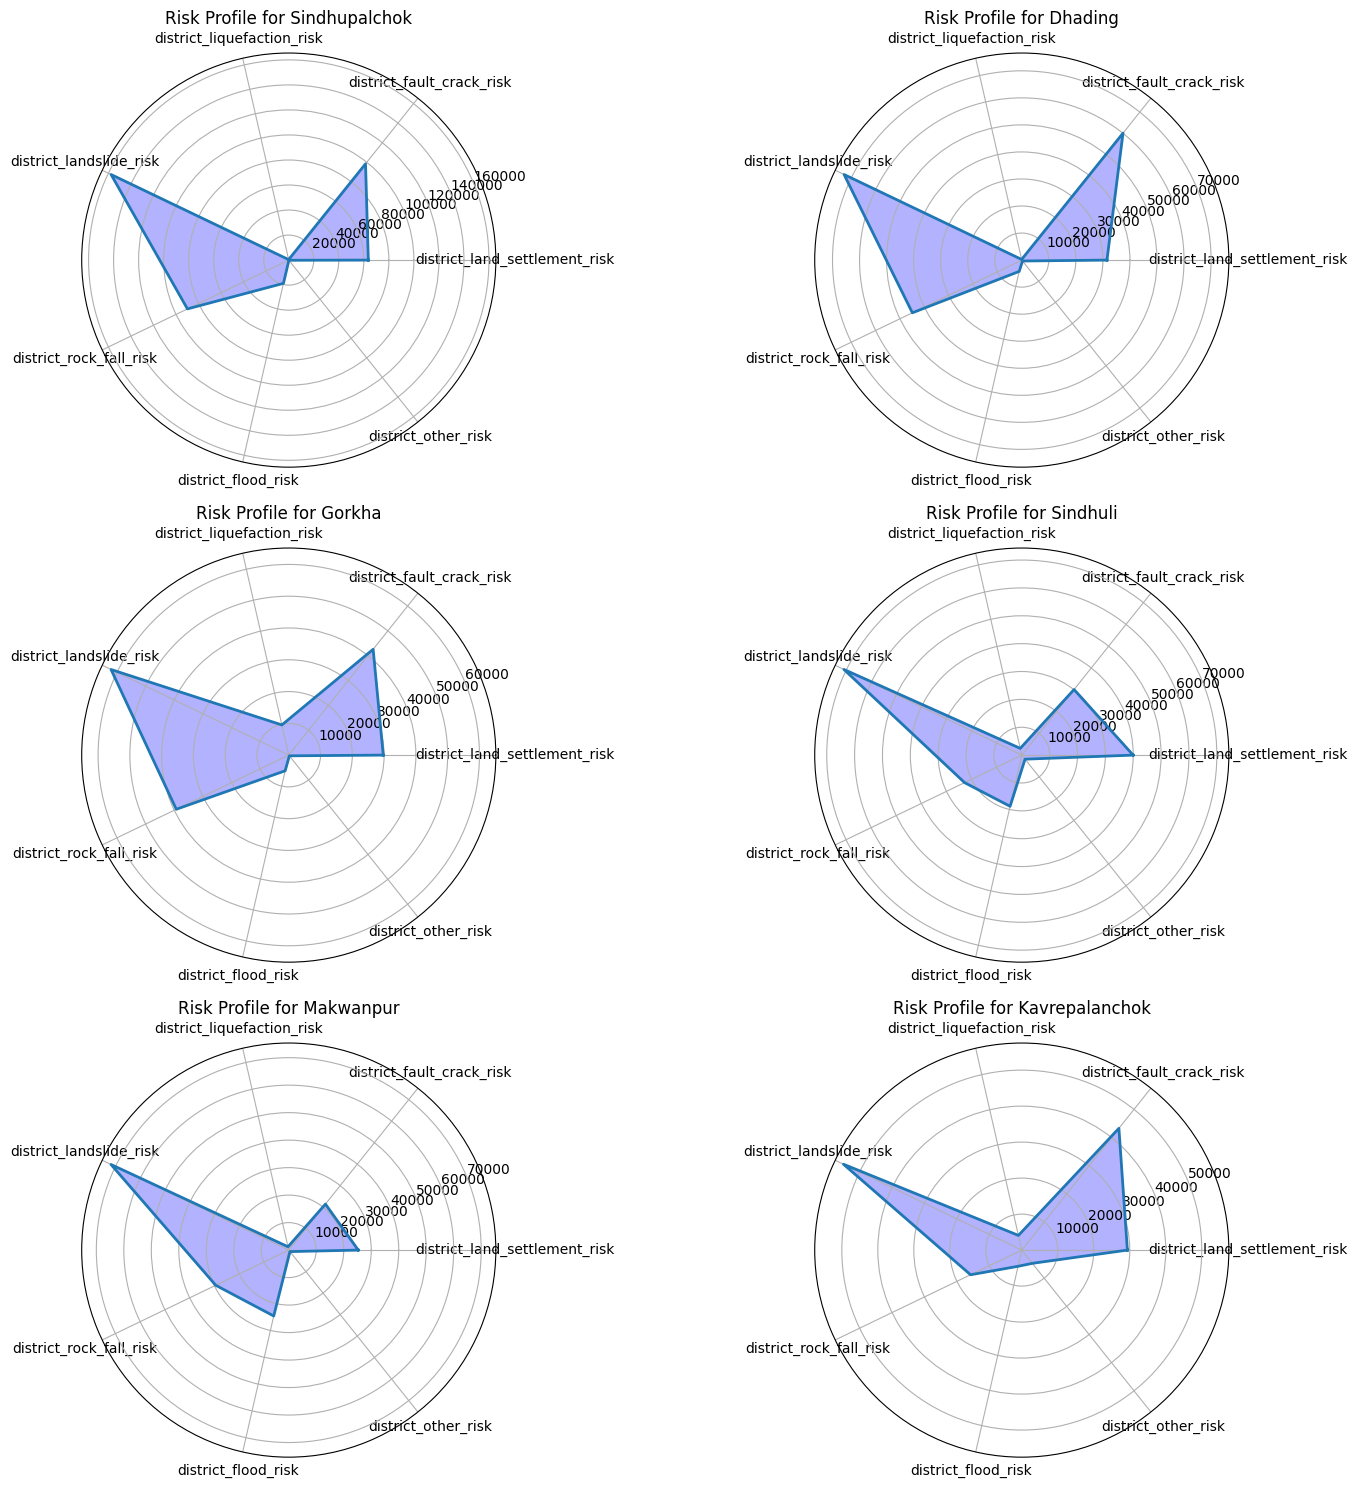

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

# Assuming df is already defined and contains your data
# List of risk columns
risks = ['district_land_settlement_risk', 'district_fault_crack_risk', 'district_liquefaction_risk',
         'district_landslide_risk', 'district_rock_fall_risk', 'district_flood_risk', 'district_other_risk']

# Aggregate risk data by district name
aggregated_df = df.groupby('district_name')[risks].sum().reset_index()

# Calculate total risk for each unique district
aggregated_df['total_risk'] = aggregated_df[risks].sum(axis=1)

# Get the top 6 districts with the highest total risk
number_districts = 6
top_districts = aggregated_df.nlargest(number_districts, 'total_risk')[['district_name', 'total_risk']]

# Set up the radar chart subplots (3 rows and 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 15), subplot_kw=dict(polar=True))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through top districts and create radar charts
for ax, (index, row) in zip(axes, top_districts.iterrows()):
    district_name = row['district_name']
    district_data = aggregated_df[aggregated_df['district_name'] == district_name][risks].values.flatten()

    # Close the circular graph
    values = district_data.tolist()
    values += values[:1]

    # Compute angles
    angles = [n / float(len(risks)) * 2 * pi for n in range(len(risks))]
    angles += angles[:1]

    # Radar chart
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color='blue', alpha=0.3)

    # Add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(risks)
    ax.set_title(f'Risk Profile for {district_name}', size=12)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


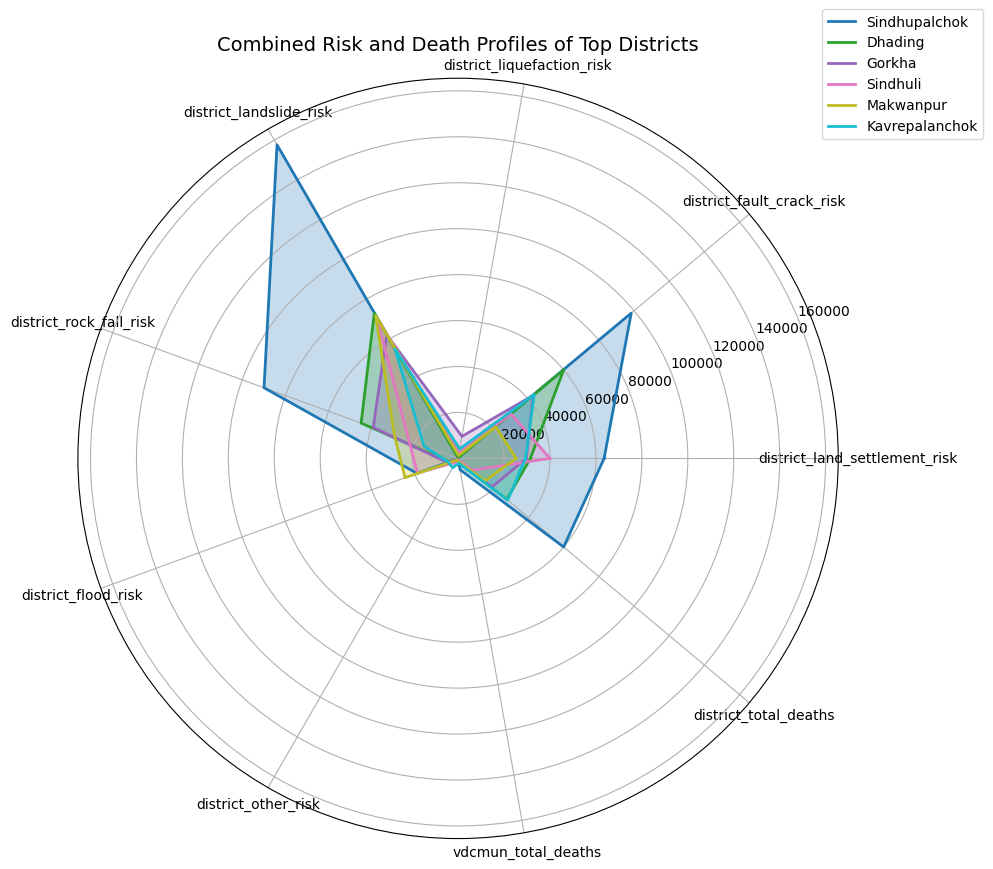

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import numpy as np

# Assuming df is already defined and contains your data
# List of risk and death-related columns
risks = ['district_land_settlement_risk', 'district_fault_crack_risk',
         'district_liquefaction_risk', 'district_landslide_risk',
         'district_rock_fall_risk', 'district_flood_risk', 'district_other_risk']

deaths = ['vdcmun_total_deaths', 'district_total_deaths']  # Replace with your actual death-related columns

# Aggregate data by district name
aggregated_df = df.groupby('district_name')[risks + deaths].sum().reset_index()

# Calculate total risk and total deaths for each district
aggregated_df['total_risk'] = aggregated_df[risks].sum(axis=1)
aggregated_df['total_deaths'] = aggregated_df[deaths].sum(axis=1)

# Get the top 6 districts based on total risk and deaths combined
aggregated_df['combined_score'] = aggregated_df['total_risk'] + aggregated_df['total_deaths']
top_districts = aggregated_df.nlargest(6, 'combined_score')

# Set up radar chart parameters
categories = risks + deaths
num_vars = len(categories)

# Compute angles for the radar chart
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Set up the plot
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Loop through top districts and plot their profiles
colors = plt.cm.tab10(np.linspace(0, 1, len(top_districts)))  # Assign unique colors
for color, (_, row) in zip(colors, top_districts.iterrows()):
    district_name = row['district_name']
    values = row[categories].values.flatten().tolist()
    values += values[:1]  # Close the circular graph

    ax.plot(angles, values, linewidth=2, linestyle='solid', label=district_name, color=color)
    ax.fill(angles, values, color=color, alpha=0.25)

# Add labels for each category
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_title('Combined Risk and Death Profiles of Top Districts', size=14, pad=20)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=10)
plt.tight_layout()
plt.show()


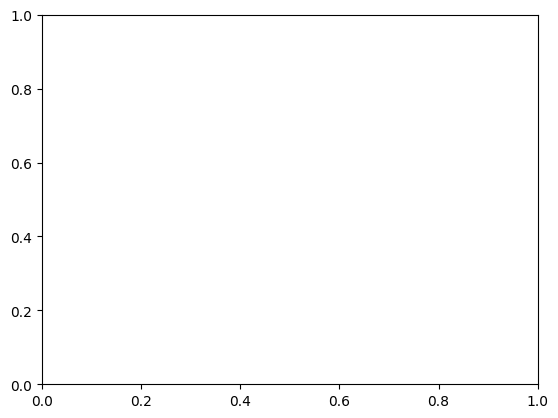

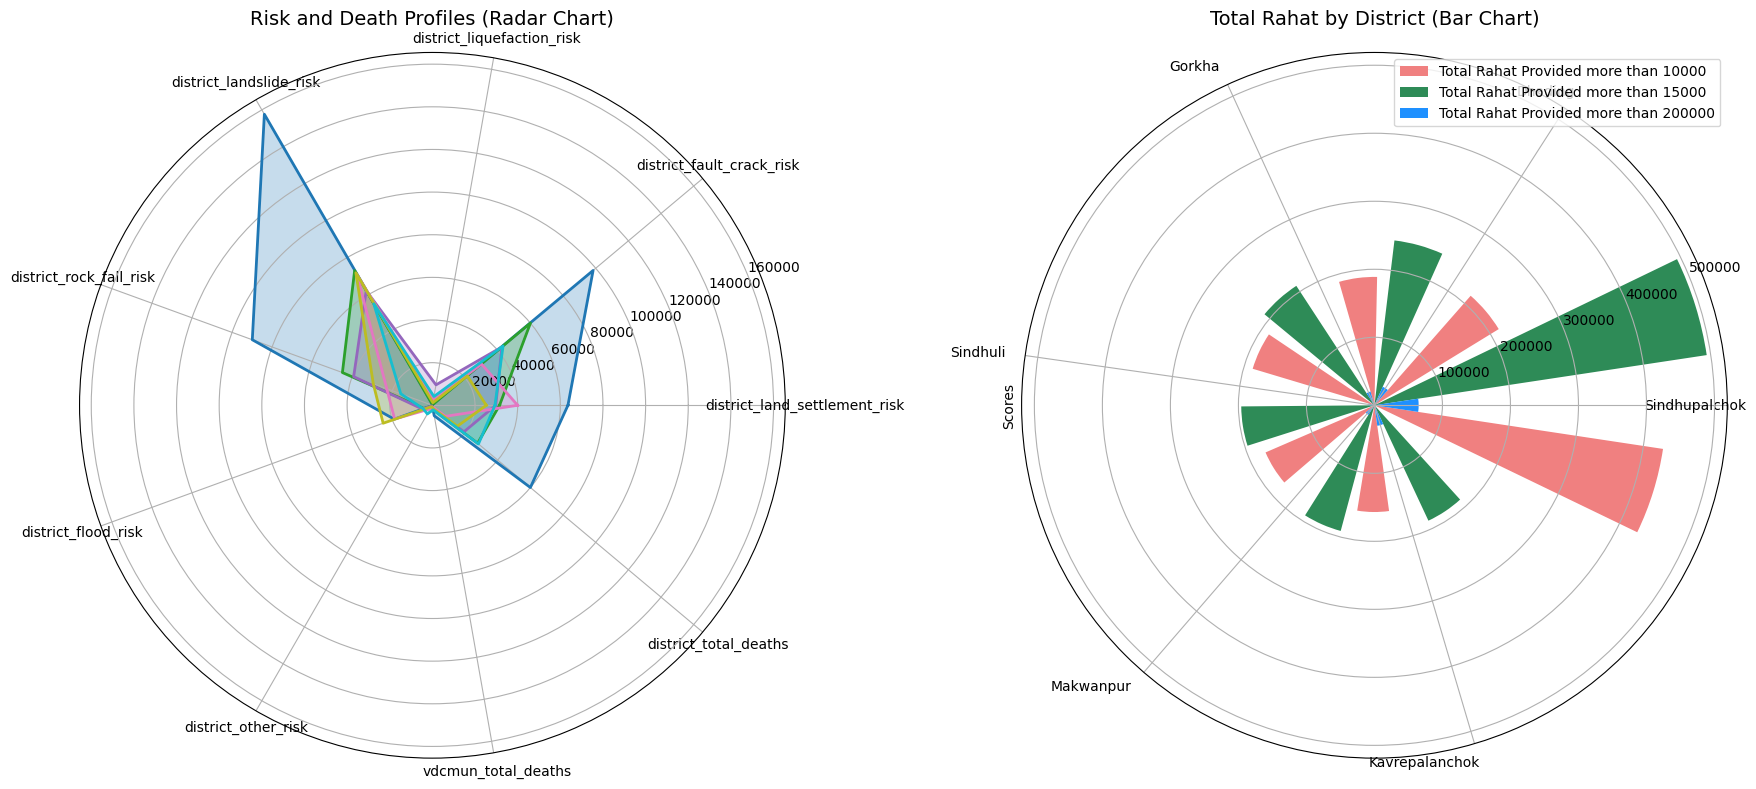

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import numpy as np

# Assuming df is already defined and contains your data
# List of risk and death-related columns
risks = ['district_land_settlement_risk', 'district_fault_crack_risk',
         'district_liquefaction_risk', 'district_landslide_risk',
         'district_rock_fall_risk', 'district_flood_risk', 'district_other_risk']

deaths = ['vdcmun_total_deaths', 'district_total_deaths']  # Replace with your actual death-related columns

# Aggregate data by district name
aggregated_df = df.groupby('district_name')[risks + deaths].sum().reset_index()

# Calculate total risk and total deaths for each district
aggregated_df['total_risk'] = aggregated_df[risks].sum(axis=1)
aggregated_df['total_deaths'] = aggregated_df[deaths].sum(axis=1)

# Get the top 6 districts based on total risk and deaths combined
aggregated_df['combined_score'] = aggregated_df['total_risk'] + aggregated_df['total_deaths']
top_districts = aggregated_df.nlargest(6, 'combined_score')

# Set up radar chart parameters
categories = risks + deaths
num_vars = len(categories)

# Compute angles for the radar chart
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Set up the plot with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'polar': True} if plt.gca().get_subplotspec().is_first_col() else {})

# Radar Chart (Left subplot)
ax_radar = axes[0]
colors = plt.cm.tab10(np.linspace(0, 1, len(top_districts)))  # Assign unique colors
for color, (_, row) in zip(colors, top_districts.iterrows()):
    district_name = row['district_name']
    values = row[categories].values.flatten().tolist()
    values += values[:1]  # Close the circular graph

    ax_radar.plot(angles, values, linewidth=2, linestyle='solid', label=district_name, color=color)
    ax_radar.fill(angles, values, color=color, alpha=0.25)

# Add labels for each category
ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories, fontsize=10)
ax_radar.set_title('Risk and Death Profiles (Radar Chart)', size=14, pad=20)

# Bar Chart (Right subplot)
ax_bar = axes[1]
bar_width = 0.3
x = np.arange(len(top_districts))
ax_bar.bar(x - bar_width, top_districts['total_risk'], bar_width, label='Total Rahat Provided more than 10000', color='lightcoral')
ax_bar.bar(x + bar_width, top_districts['combined_score'], bar_width, label='Total Rahat Provided more than 15000', color='seagreen')
ax_bar.bar(x, top_districts['total_deaths'], bar_width, label='Total Rahat Provided more than 200000', color='dodgerblue')

# Add labels, title, and legend for the bar chart
ax_bar.set_xticks(x)
ax_bar.set_xticklabels(top_districts['district_name'], rotation=45, ha='right')
ax_bar.set_title('Total Rahat by District (Bar Chart)', size=14, pad=20)
ax_bar.set_ylabel('Scores')
ax_bar.legend(fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


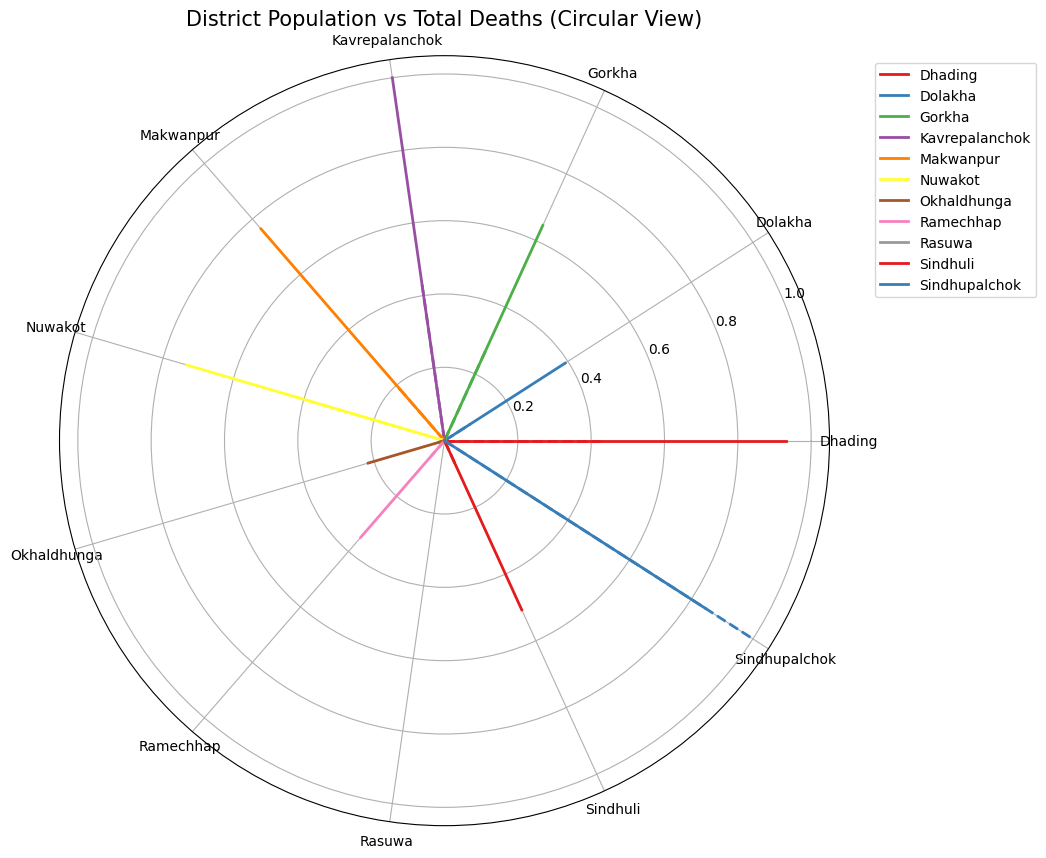

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame (replace with your actual DataFrame)
# df = pd.read_csv('your_data.csv')

# Aggregate the DataFrame by district_name
df_aggregated = df.groupby('district_name').agg({
    'district_population': 'sum',
    'district_total_deaths': 'sum'
}).reset_index()

# Normalize the values for polar coordinates
df_aggregated['normalized_population'] = (df_aggregated['district_population'] - df_aggregated['district_population'].min()) / (df_aggregated['district_population'].max() - df_aggregated['district_population'].min())
df_aggregated['normalized_deaths'] = (df_aggregated['district_total_deaths'] - df_aggregated['district_total_deaths'].min()) / (df_aggregated['district_total_deaths'].max() - df_aggregated['district_total_deaths'].min())

# Determine the number of districts
num_districts = df_aggregated.shape[0]
angles = np.linspace(0, 2 * np.pi, num_districts, endpoint=False).tolist()

# Make the plot circular by repeating the first values
normalized_population = df_aggregated['normalized_population'].tolist() + [df_aggregated['normalized_population'].iloc[0]]
normalized_deaths = df_aggregated['normalized_deaths'].tolist() + [df_aggregated['normalized_deaths'].iloc[0]]
angles += angles[:1]

# Create a polar plot
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Plot population vs deaths in polar coordinates
for i in range(num_districts):
    ax.plot([angles[i], angles[i]], [0, normalized_population[i]], label=df_aggregated['district_name'].iloc[i], color=sns.color_palette('Set1', n_colors=num_districts)[i], linewidth=2)
    ax.plot([angles[i], angles[i]], [0, normalized_deaths[i]], color=sns.color_palette('Set1', n_colors=num_districts)[i], linestyle='--', linewidth=2)

# Add labels and title
ax.set_xticks(angles[:-1])
ax.set_xticklabels(df_aggregated['district_name'], fontsize=10)
plt.title('District Population vs Total Deaths (Circular View)', size=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
